# Prediction of creditworthiness for credit card applications
## Introduction
In this project we aim to predict the creditworthiness of clients who submited a credit card application to the Pro National Bank. The goal is to create a model capable of estimating the creditworthiness of a customer, in order to help the dedicated team understand whether or not to accept the application for a credit card.


In [41]:
from tools import *
from customers_handler import Customer

## Dataset
Pro National Bank has provided two different datasets for this project. The first dataset contains information about the customers who have applied for a credit card. The second dataset contains information about the customers who have been granted a credit card. The datasets are as follows:

In [42]:
credit_df = pd.read_csv('../data/credit_record.csv')
application_df = pd.read_csv('../data/application_record.csv')
credit_df.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [43]:
application_df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [44]:
total_number_of_applications = application_df.shape[0]
total_number_of_conceeded_credit_card = credit_df['ID'].unique().shape[0]
print(total_number_of_applications)
print(total_number_of_conceeded_credit_card)

438557
45985


The two datasets are composed by respectively 438557 and 13153 clients.
The application dataset contains the following features:
- `ID`: the unique identifier of the client;
- `CODE_GENDER`: the client gender;
- `FLAG_OWN_CAR`: whether the client owns a car or not;
- `FLAG_OWN_REALTY`: whether the client owns a realty or not;
- `CNT_CHILDREN`: the number of children the client has;
- `AMT_INCOME_TOTAL`: the total income of the client;
- `NAME_INCOME_TYPE`: the type of income of the client;
- `NAME_EDUCATION_TYPE`: the education level of the client;
- `NAME_FAMILY_STATUS`: the family status of the client;
- `NAME_HOUSING_TYPE`: the housing type of the client;
- `DAYS_BIRTH`: the age of the client in days, relative to the application date (negative value);
- `DAYS_EMPLOYED`: the number of days the client has been employed, relative to the application date (negative value if the client is employed);
- `FLAG_MOBIL`: whether the client provided a mobile phone number or not;
- `FLAG_WORK_PHONE`: whether the client provided a work phone number or not;
- `FLAG_PHONE`: whether the client provided a phone number or not;
- `FLAG_EMAIL`: whether the client provided an email or not;
- `OCCUPATION_TYPE`: the occupation of the client;
- `CNT_FAM_MEMBERS`: the number of family members of the client.<br><br>


The credit card dataset contains the following features:
- `ID`: the unique identifier of the client;
- `MONTHS_BALANCE`: the month of the record relative to the application date;
- `STATUS`: the status of the credit card of the client, where 0 means 1-29 days past due, 1 means 30-59 days past due, 2 means 60-89 days overdue, 
3 means 90-119 days overdue, 4 means 120-149 days overdue, 5 means over 150 days overdue, and C means paid off that month and X means no loan for the month.


In [45]:
credit_df = credit_df[credit_df['ID'].isin(application_df['ID'])]
credit_df.reset_index(drop=True, inplace=True)
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5008804,0,C
1,5008804,-1,C
2,5008804,-2,C
3,5008804,-3,C
4,5008804,-4,C


## Datasets exploration and cleaning
In this section we will explore the datasets in order to understand the data and the features we have at our disposal.
Starting from *credit_df*, we can see that for every ID there can be multiple entries, each one representing a different month of the credit card status.
The first thing we can do is select valid IDs from the dataset in order to consider only customers with a history large enough to provide sufficient information on the client's status to get the full picture of the client's reliability. We decided to consider only the clients with **at least 24 months** of history, which is the minimum number of months required to have a full picture of the client's status.

In [46]:
credit_df['ID'].value_counts()

ID
5148819    61
5115964    61
5061741    61
5078799    61
5061685    61
           ..
5139553     1
5069020     1
5097025     1
5023604     1
5092141     1
Name: count, Length: 36457, dtype: int64

In [47]:
value_counts = credit_df['ID'].value_counts()
idx = value_counts[value_counts > 24].index
credit_df = credit_df[credit_df["ID"].isin(idx)]

credit_df.reset_index(drop=True, inplace=True)
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5008806,0,C
1,5008806,-1,C
2,5008806,-2,C
3,5008806,-3,C
4,5008806,-4,C


Once obtained the valid IDs, we can extract from the *application_df* dataframe the subset of application requests that have already been accepted by the bank.
We call this new dataframe *approved_applications*. 

In [48]:
approved_applications = application_df[np.isin(application_df['ID'], credit_df['ID'])]
approved_applications.reset_index(drop=True, inplace=True)
approved_applications.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
1,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
2,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
3,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0
4,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
5,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.0
6,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0
7,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.0
8,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.0
9,5008838,M,N,Y,1,405000.0,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3.0


We can now obserse the distribution of the features in the *approved_applications* dataframe, in order to understand the characteristics of the clients who have been granted a credit card.
First of all, we can see that there are some missing values in the **OCCUPATION_TYPE** column and in particular, we observe a missing of 4068 values, which is a significant amount of missing data.
Before decide how to handle the missing values, we can observe the distribution of the other features in the dataframe.

In [49]:
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13153 non-null  int64  
 1   CODE_GENDER          13153 non-null  object 
 2   FLAG_OWN_CAR         13153 non-null  object 
 3   FLAG_OWN_REALTY      13153 non-null  object 
 4   CNT_CHILDREN         13153 non-null  int64  
 5   AMT_INCOME_TOTAL     13153 non-null  float64
 6   NAME_INCOME_TYPE     13153 non-null  object 
 7   NAME_EDUCATION_TYPE  13153 non-null  object 
 8   NAME_FAMILY_STATUS   13153 non-null  object 
 9   NAME_HOUSING_TYPE    13153 non-null  object 
 10  DAYS_BIRTH           13153 non-null  int64  
 11  DAYS_EMPLOYED        13153 non-null  int64  
 12  FLAG_MOBIL           13153 non-null  int64  
 13  FLAG_WORK_PHONE      13153 non-null  int64  
 14  FLAG_PHONE           13153 non-null  int64  
 15  FLAG_EMAIL           13153 non-null 

An anomaly is detected in the data. The column **DAYS_EMPLOYED** has a value of 365243 for some of the records. This value is not possible as it would mean that the person has been working for 1000 years. Looking more carefully at the data, we can see that the value 365243 is present only for the clients who are retired (2150 clients).  

In [50]:
for column in approved_applications.columns:
    if column == "ID":
        continue
    print("--------------------")
    print(column, approved_applications[column].nunique())
    print(approved_applications[column].value_counts())
    print("--------------------")
    

--------------------
CODE_GENDER 2
CODE_GENDER
F    8743
M    4410
Name: count, dtype: int64
--------------------
--------------------
FLAG_OWN_CAR 2
FLAG_OWN_CAR
N    7903
Y    5250
Name: count, dtype: int64
--------------------
--------------------
FLAG_OWN_REALTY 2
FLAG_OWN_REALTY
Y    8584
N    4569
Name: count, dtype: int64
--------------------
--------------------
CNT_CHILDREN 7
CNT_CHILDREN
0     9141
1     2620
2     1207
3      162
4       17
5        4
14       2
Name: count, dtype: int64
--------------------
--------------------
AMT_INCOME_TOTAL 194
AMT_INCOME_TOTAL
135000.0    1517
180000.0    1221
112500.0    1040
225000.0    1017
157500.0    1009
            ... 
191250.0       1
531000.0       1
634500.0       1
165150.0       1
215100.0       1
Name: count, Length: 194, dtype: int64
--------------------
--------------------
NAME_INCOME_TYPE 5
NAME_INCOME_TYPE
Working                 6697
Commercial associate    3134
Pensioner               2157
State servant           1

In [51]:
print(approved_applications[approved_applications['DAYS_EMPLOYED'] == 0].shape[0])
(approved_applications[(approved_applications['DAYS_EMPLOYED'] > 0) & (approved_applications['NAME_INCOME_TYPE'] == 'Pensioner')].shape)[0]

0


2150

For those clients, we replace the NaN value of **OCCUPATION_TYPE** with the string 'Unemployed', and let see if all the missing values have been filled.

In [52]:
approved_applications.loc[approved_applications['DAYS_EMPLOYED'] > 0, 'OCCUPATION_TYPE'] = "Unemployed"
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   13153 non-null  int64  
 1   CODE_GENDER          13153 non-null  object 
 2   FLAG_OWN_CAR         13153 non-null  object 
 3   FLAG_OWN_REALTY      13153 non-null  object 
 4   CNT_CHILDREN         13153 non-null  int64  
 5   AMT_INCOME_TOTAL     13153 non-null  float64
 6   NAME_INCOME_TYPE     13153 non-null  object 
 7   NAME_EDUCATION_TYPE  13153 non-null  object 
 8   NAME_FAMILY_STATUS   13153 non-null  object 
 9   NAME_HOUSING_TYPE    13153 non-null  object 
 10  DAYS_BIRTH           13153 non-null  int64  
 11  DAYS_EMPLOYED        13153 non-null  int64  
 12  FLAG_MOBIL           13153 non-null  int64  
 13  FLAG_WORK_PHONE      13153 non-null  int64  
 14  FLAG_PHONE           13153 non-null  int64  
 15  FLAG_EMAIL           13153 non-null 

In [53]:
print("Percentage of Nan values in occupation type: %.2f%%" % (approved_applications['OCCUPATION_TYPE'].isna().sum() *100 /approved_applications.shape[0]))

Percentage of Nan values in occupation type: 14.58%


In [54]:
approved_applications = approved_applications.drop(columns=["OCCUPATION_TYPE"])

Since the **OCCUPATION_TYPE** still presents a strong percentage of missing values and there are a couple of columns that already contain information about the client's income, we decide to drop the **OCCUPATION_TYPE** column from the dataframe.<br>
Moreover, we rename the **DAYS_BIRTH** column to **AGE** and the **DAYS_EMPLOYED** column to **YEARS_EMPLOYED**, and perform the appropriate transformations in order to make the dataframe more readable.
In particular we take the positive values of **DAYS_EMPLOYED** and set them to 0, since they represent the clients who are retired, and then we converted the negative days into positive years.
Moreover we removed columns **GENDER** and **CNT_CHILDREN** since: the first is not relevant for the analysis, the second is already included in the **CNT_FAM_MEMBERS** column.

In [55]:
approved_applications = preprocess_dataframe(approved_applications)

Let see the distribution of the features in the dataframe after the cleaning:
* *approved_applications* dataframe:

In [56]:
approved_applications.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008806,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,2.0
1,5008810,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1.0
2,5008811,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,1.0
3,5112956,Y,Y,270000.0,Working,Higher education,Married,House / apartment,46,2,1,1,1,1,2.0
4,5008825,Y,N,130500.0,Working,Incomplete higher,Married,House / apartment,29,3,1,0,0,0,2.0


* *credit_df* dataframe:

In [57]:
print("Unique ID : ", credit_df['ID'].nunique())
print(credit_df['MONTHS_BALANCE'].value_counts())

Unique ID :  13153
MONTHS_BALANCE
-24    12877
-23    12819
-22    12765
-21    12696
-20    12628
       ...  
-56     1153
-57      903
-58      688
-59      462
-60      234
Name: count, Length: 61, dtype: int64


and then we can see credit information of client with ID 5008810, for example, in the *credit_df* dataframe:

In [58]:
credit_df[credit_df['ID'] == 5008810]

,ID,MONTHS_BALANCE,STATUS
30,5008810,0,C
31,5008810,-1,C
32,5008810,-2,C
33,5008810,-3,C
34,5008810,-4,C
35,5008810,-5,C
36,5008810,-6,C
37,5008810,-7,C
38,5008810,-8,C
39,5008810,-9,C


Let see some statistics of numerical variables of the cleaned dataframe:

In [59]:
round(approved_applications[["AMT_INCOME_TOTAL", "AGE", "YEARS_EMPLOYED", "CNT_FAM_MEMBERS"]].describe(), 2)

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS
count,13153.00,13153.00,13153.00,13153.00
mean,189267.09,43.91,6.17,2.22
std,102034.01,11.07,6.76,0.90
min,27000.00,22.00,0.00,1.00
25%,126000.00,35.00,1.00,2.00
50%,166500.00,43.00,4.00,2.00
75%,225000.00,53.00,9.00,3.00
max,1575000.00,68.00,42.00,15.00


## Creditworthiness computation

In order to compute the creditworthiness of the clients, we need to create a new feature that represents the creditworthiness of the client. 
We can use the **STATUS** column of the *credit_df* dataframe to compute the creditworthiness of the clients. We can define the creditworthiness of 
a client as the percentage of months in which the client has been in a good standing position, i.e. the percentage of months in which the client has 
not been in a delayed position. We can compute this percentage for each client and then use it as a feature to predict the creditworthiness of the client. 
Moreover we can use the **MONTHS_BALANCE** column to compute the number of months of history of the client, which is a useful feature to understand the reliability 
of the client.
We finally can consider the last 6 months of the client's history to understand the creditworthiness trend of the client.
In **customers_handler/Customer.py** we define the class Customer, which contains the method *compute_reliability* that computes the creditworthiness of the client.
The reliability is computed in a range from 0 to 7, where 0 means that the client has definitely a bad creditworthiness and 7 means that the client has a strong creditworthiness. To be considered a good client, the client must have a reliability of at least 5.
As described in method *get_history_reliability*, if the client:
1. has a percentage higher than 5% of "over 150 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 0; 
2. has a percentage higher than 5% of "120-149 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 1; 
3. has a percentage higher than 10% of "90-119 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 2;
4. has a percentage between 5 and 10% of "90-119 days overdue" status or higher than 15% of "60-89 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 3;
5. has a percentage between 5 and 15% of "60-89 days overdue" status or higher than 15% of "30-59 days overdue" status, the client is considered to have a bad creditworthiness and the reliability is set to 4;
6. has a percentage between 5 and 15% of "30-59 days overdue" status or higher than 15% of "1-29 days overdue" status, the client is considered to have a good creditworthiness and the reliability is set to 5;
7. has a percentage between 5 and 15% of "1-29 days overdue" status or lower than 70% of "paid off month" status, the client is considered to have a good creditworthiness and the reliability is set to 6;
8. has at least 70% of "paid off month" status, the client is considered to have a good creditworthiness and the reliability is set to 7.<br>

Then the reliability of last 6 months is computed as follow:
1. if the client has at least 1 month of "over 150 days overdue" or "120-149 days overdue" status, the reliability is set to 0;
2. if the client has at least 1 month of "90-119 days overdue" status, the reliability is set to 1;
3. if the client has at least 1 month of "60-89 days overdue" status, the reliability is multiplied by 0.35;
4. if the client has at least 1 month of "30-59 days overdue" status, the reliability is multiplied by 1.1 if $reliability\times1.1 < 3$, otherwise the reliability is multiplied by 0.65;
5. if the client has at least 1 month of "1-29 days overdue" status, the reliability is multiplied by 1.2 if $reliability\times1.2 < 5$, otherwise the reliability is not changed;
6. if the client has at least 1 month of "paid off month" status, the reliability is multiplied by 1.25 if $reliability\times1.25 < 6$, otherwise the reliability is not changed.
7. if the client has at least 1 month of "no loan for the month" status, the reliability is multiplied by 1.35 if $reliability\times1.35 < 7$ else it is fixed to 7.<br>

Finally the creditworthiness is computed as the 75% of the reliability of the history and the 25% of the reliability of the last 6 months.

In [60]:
ids = approved_applications['ID'].unique()
customers_creditworthiness = { "CUSTOMER_RELIABILITY": [], "BAD_CUSTOMER": []}

for id in ids:
    client=Customer(id, approved_applications[(approved_applications['ID'] == id).drop(columns=['ID'])], credit_df[(credit_df['ID'] == id).drop(columns=['ID'])])
    customers_creditworthiness["CUSTOMER_RELIABILITY"].append(client.get_reliability())
    customers_creditworthiness["BAD_CUSTOMER"].append(client.get_bad_client())

approved_applications = approved_applications.join(pd.DataFrame(customers_creditworthiness))
       

Let see creditworthiness distrubution of the clients in the *approved_applications* dataframe:

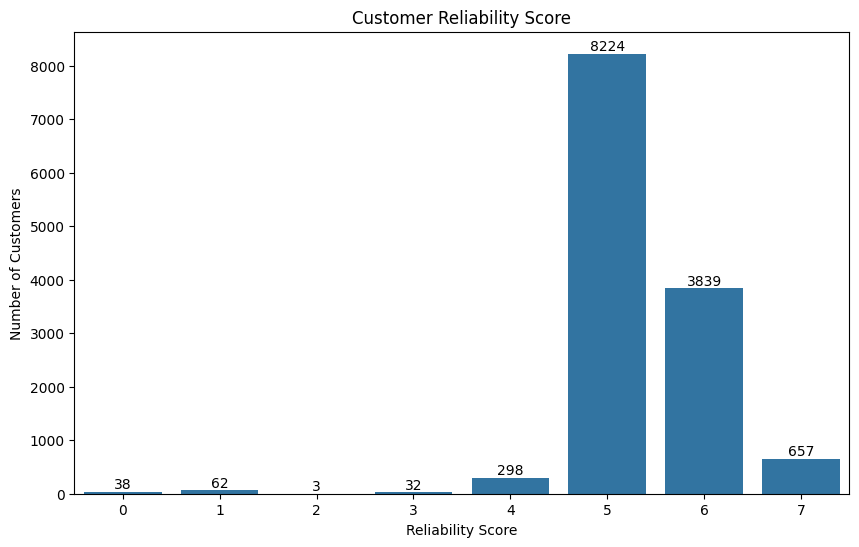

In [61]:
_, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='CUSTOMER_RELIABILITY', data=approved_applications)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.xlabel('Reliability Score')
plt.ylabel('Number of Customers')
plt.title('Customer Reliability Score')
plt.show()



Finally let see whether a customer is a good client or not, and the distribution of the clients in the *approved_applications* dataframe. We can see that there is a significant amount of good clients in the dataframe, which is a good sign for the bank, but this means that the dasataset is unbalanced, and we need to take this into account when we will train the model.

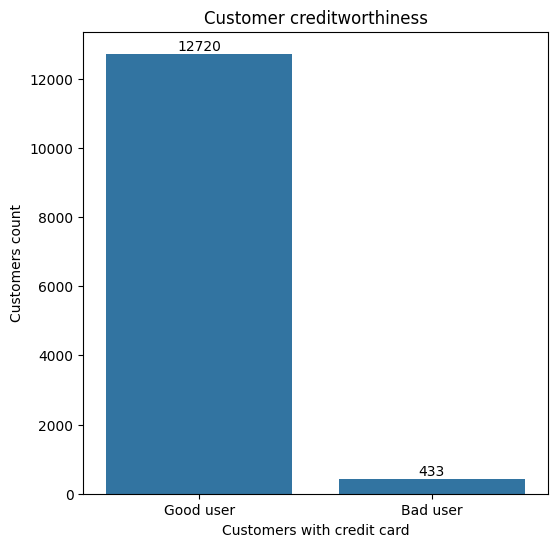

In [62]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.countplot(x='BAD_CUSTOMER', data=approved_applications)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Good user', 'Bad user'])
plt.xlabel('Customers with credit card')
plt.ylabel('Customers count')
plt.title('Customer creditworthiness')
plt.show()

In [63]:
approved_applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13153 entries, 0 to 13152
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    13153 non-null  int64  
 1   FLAG_OWN_CAR          13153 non-null  object 
 2   FLAG_OWN_REALTY       13153 non-null  object 
 3   AMT_INCOME_TOTAL      13153 non-null  float64
 4   NAME_INCOME_TYPE      13153 non-null  object 
 5   NAME_EDUCATION_TYPE   13153 non-null  object 
 6   NAME_FAMILY_STATUS    13153 non-null  object 
 7   NAME_HOUSING_TYPE     13153 non-null  object 
 8   AGE                   13153 non-null  int64  
 9   YEARS_EMPLOYED        13153 non-null  int64  
 10  FLAG_MOBIL            13153 non-null  int64  
 11  FLAG_WORK_PHONE       13153 non-null  int64  
 12  FLAG_PHONE            13153 non-null  int64  
 13  FLAG_EMAIL            13153 non-null  int64  
 14  CNT_FAM_MEMBERS       13153 non-null  float64
 15  CUSTOMER_RELIABILIT

## Correlation analysis

Once we have merged the *approved_applications* dataframe with the information about crediworthiness of the clients, we can perform a correlation analysis in order to understand the relationship between the features and the creditworthiness of the clients. We can use the Pearson correlation coefficient to understand the linear relationship between the features and the creditworthiness of the clients. We can then use the P-value of the chi-squared analysis to select the most important features to predict the creditworthiness of the clients.

In [64]:
columns_of_interest = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_HOUSING_TYPE']
cross_tab = []
for column in columns_of_interest:
    cross_tab.append(pd.crosstab(approved_applications['CUSTOMER_RELIABILITY'], approved_applications[column]))
    display(cross_tab[-1])

NAME_INCOME_TYPE,Commercial associate,Pensioner,State servant,Student,Working
CUSTOMER_RELIABILITY,,,,,
0,15,6,1,0,16
1,13,18,6,0,25
2,2,0,0,0,1
3,10,2,4,0,16
4,81,40,28,0,149
5,1989,1356,739,2,4138
6,874,615,325,6,2019
7,150,120,54,0,333


NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
CUSTOMER_RELIABILITY,,,,,
0,0,11,5,0,22
1,0,16,2,3,41
2,0,1,0,0,2
3,0,8,3,0,21
4,0,83,21,2,192
5,8,2255,306,93,5562
6,5,1112,145,42,2535
7,5,178,23,12,439


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Widow
CUSTOMER_RELIABILITY,,,,,
0,1,27,3,5,2
1,1,47,3,9,2
2,0,1,1,1,0
3,4,21,1,4,2
4,18,189,25,53,13
5,613,5869,458,953,331
6,307,2745,225,396,166
7,52,451,38,93,23


FLAG_OWN_REALTY,N,Y
CUSTOMER_RELIABILITY,,
0,10,28
1,26,36
2,1,2
3,20,12
4,128,170
5,2844,5380
6,1331,2508
7,209,448


FLAG_OWN_CAR,N,Y
CUSTOMER_RELIABILITY,,
0,25,13
1,42,20
2,2,1
3,21,11
4,181,117
5,4994,3230
6,2221,1618
7,417,240


NAME_HOUSING_TYPE,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents
CUSTOMER_RELIABILITY,,,,,,
0,0,34,2,0,0,2
1,2,47,8,1,2,2
2,0,2,0,0,0,1
3,0,29,1,0,0,2
4,0,271,9,2,7,9
5,38,7412,264,51,95,364
6,23,3446,109,29,62,170
7,2,590,27,5,10,23


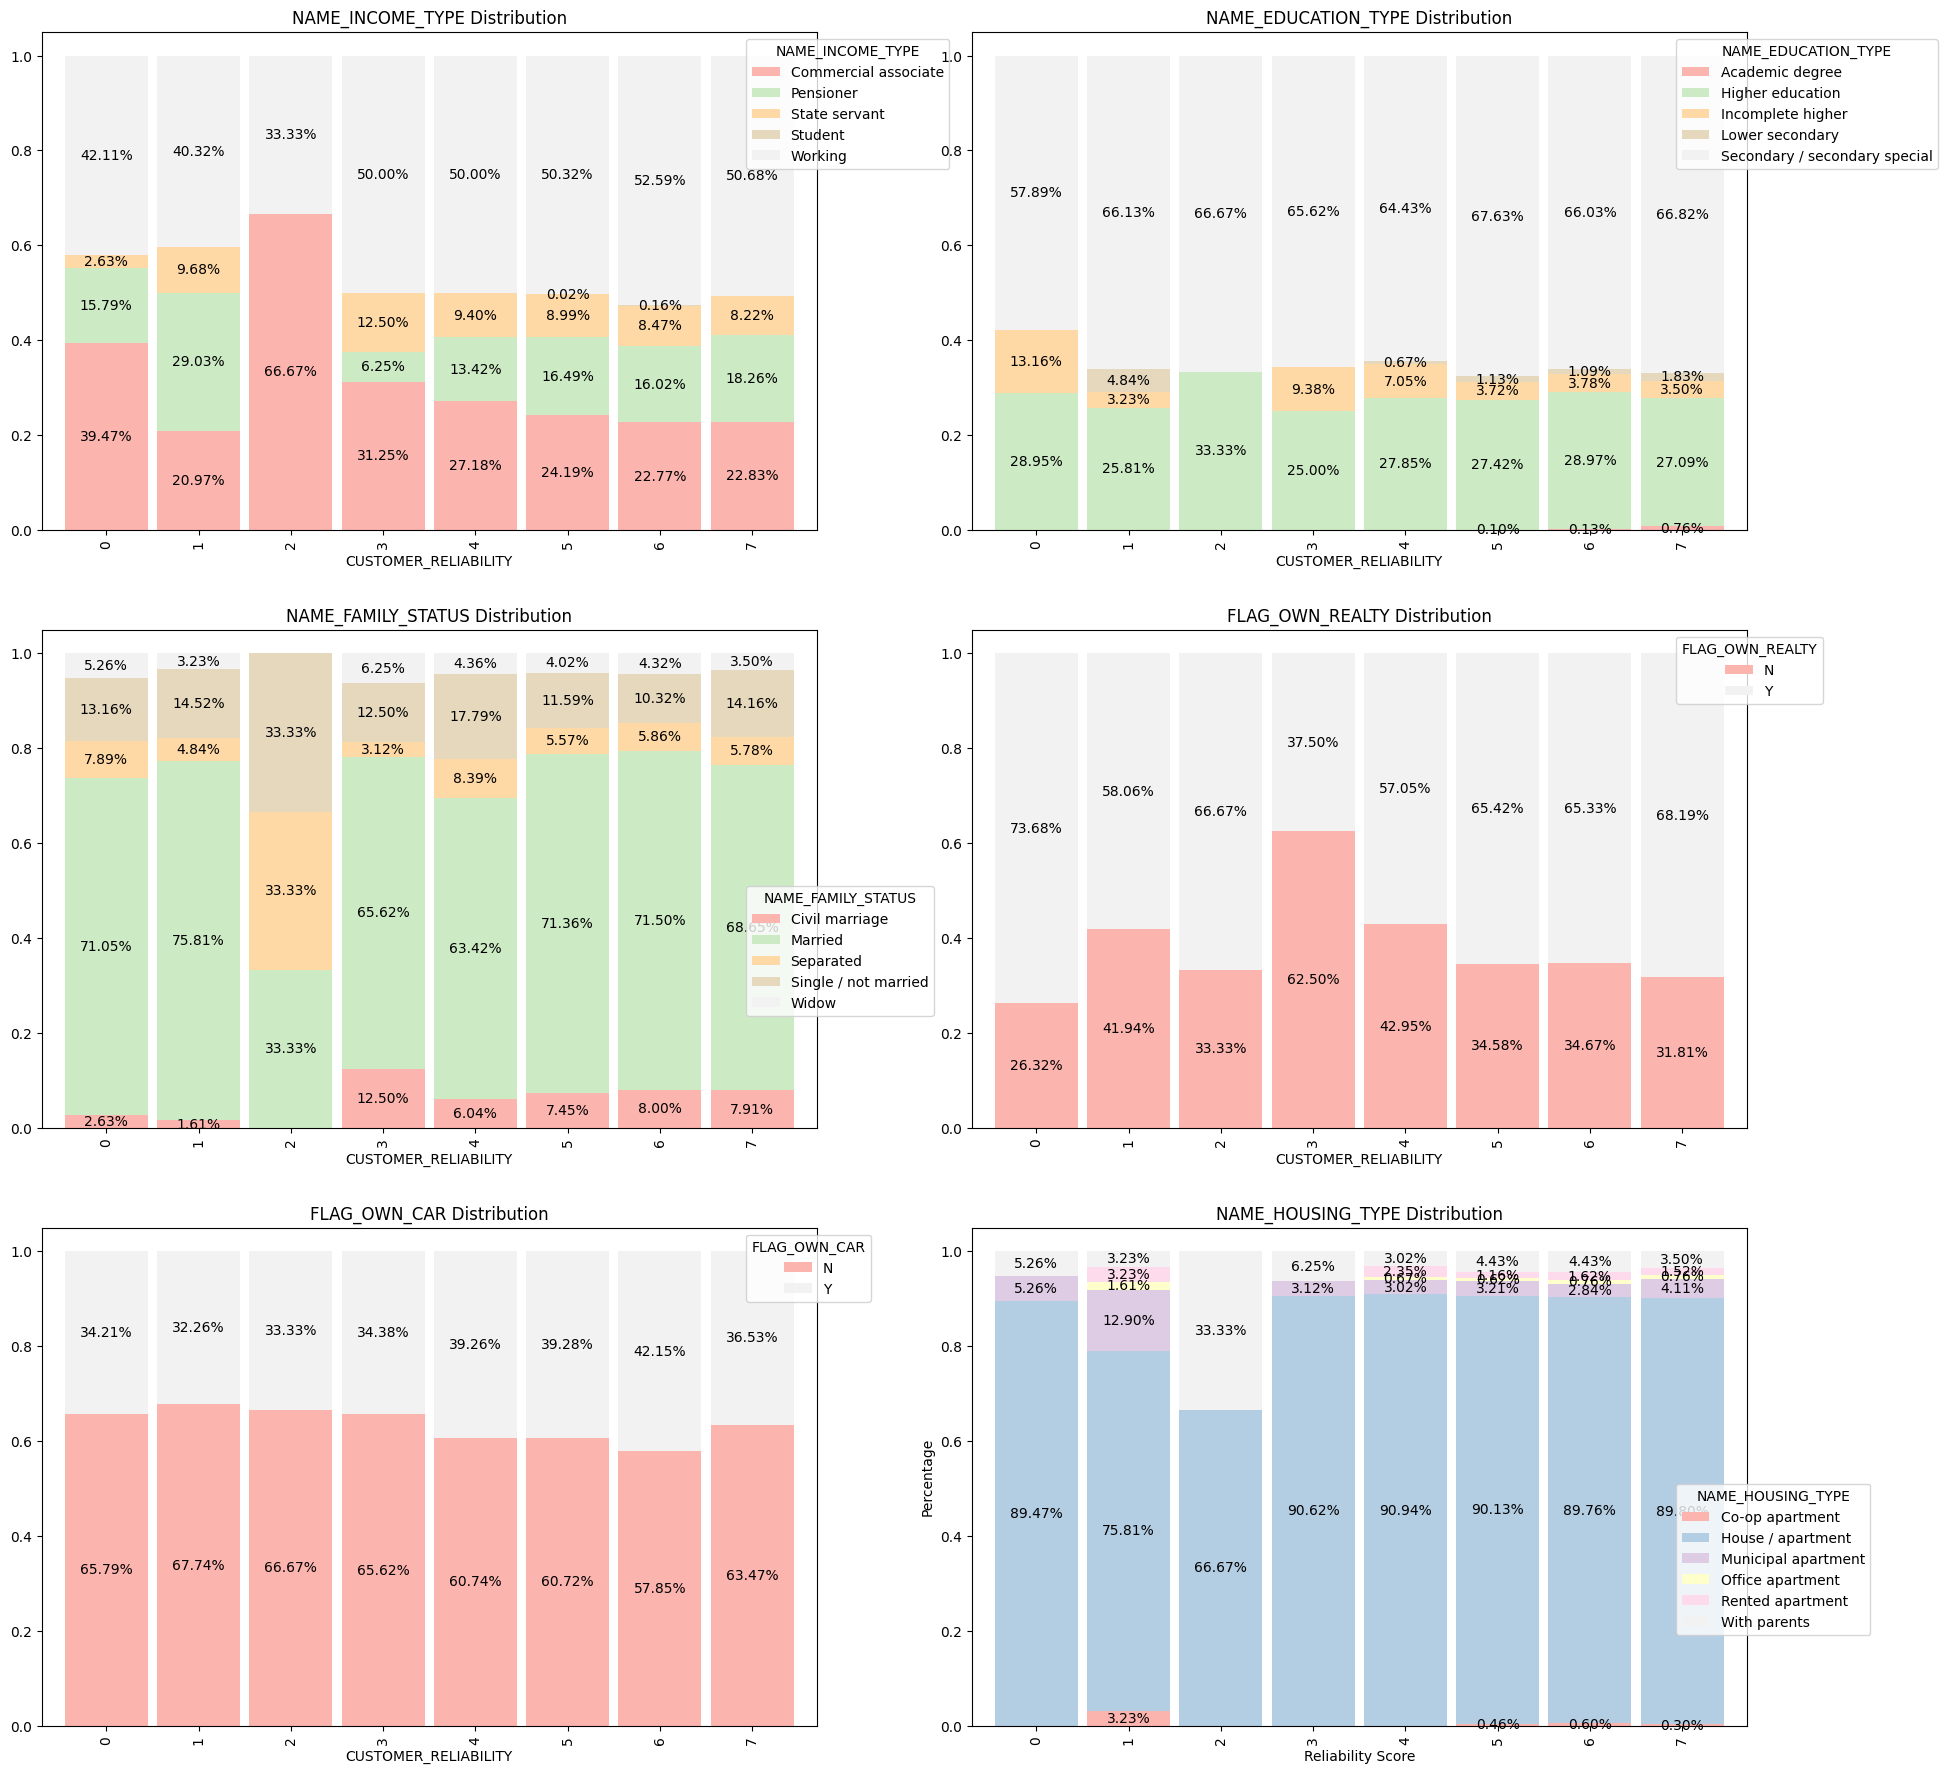

In [65]:
subplot = 0
axes = []
fig, axes = plt.subplots(3,2, figsize=(22, 22))
for column in columns_of_interest:
    cross_tab = pd.crosstab(approved_applications['CUSTOMER_RELIABILITY'], approved_applications[column])
    cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    cross_tab_plot = cross_tab.plot(kind='bar', stacked=True, width=0.9, ax=axes[int(subplot/2)][subplot%2], colormap='Pastel1')
    if column != 'NAME_FAMILY_STATUS' and column != 'NAME_HOUSING_TYPE':
        axes[int(subplot/2)][subplot%2].legend(title=column, bbox_to_anchor=(0.9, 1), loc='upper left')
    else:
        axes[int(subplot/2)][subplot%2].legend(title=column, bbox_to_anchor=(0.9, .5), loc='upper left')
    show_percentage(cross_tab_plot, cross_tab)
    plt.xlabel('Reliability Score')
    plt.ylabel('Percentage')
    axes[int(subplot/2)][subplot%2].set_title(column + ' Distribution')
    subplot += 1
#axes[-1, -1].axis('off')
plt.show() 

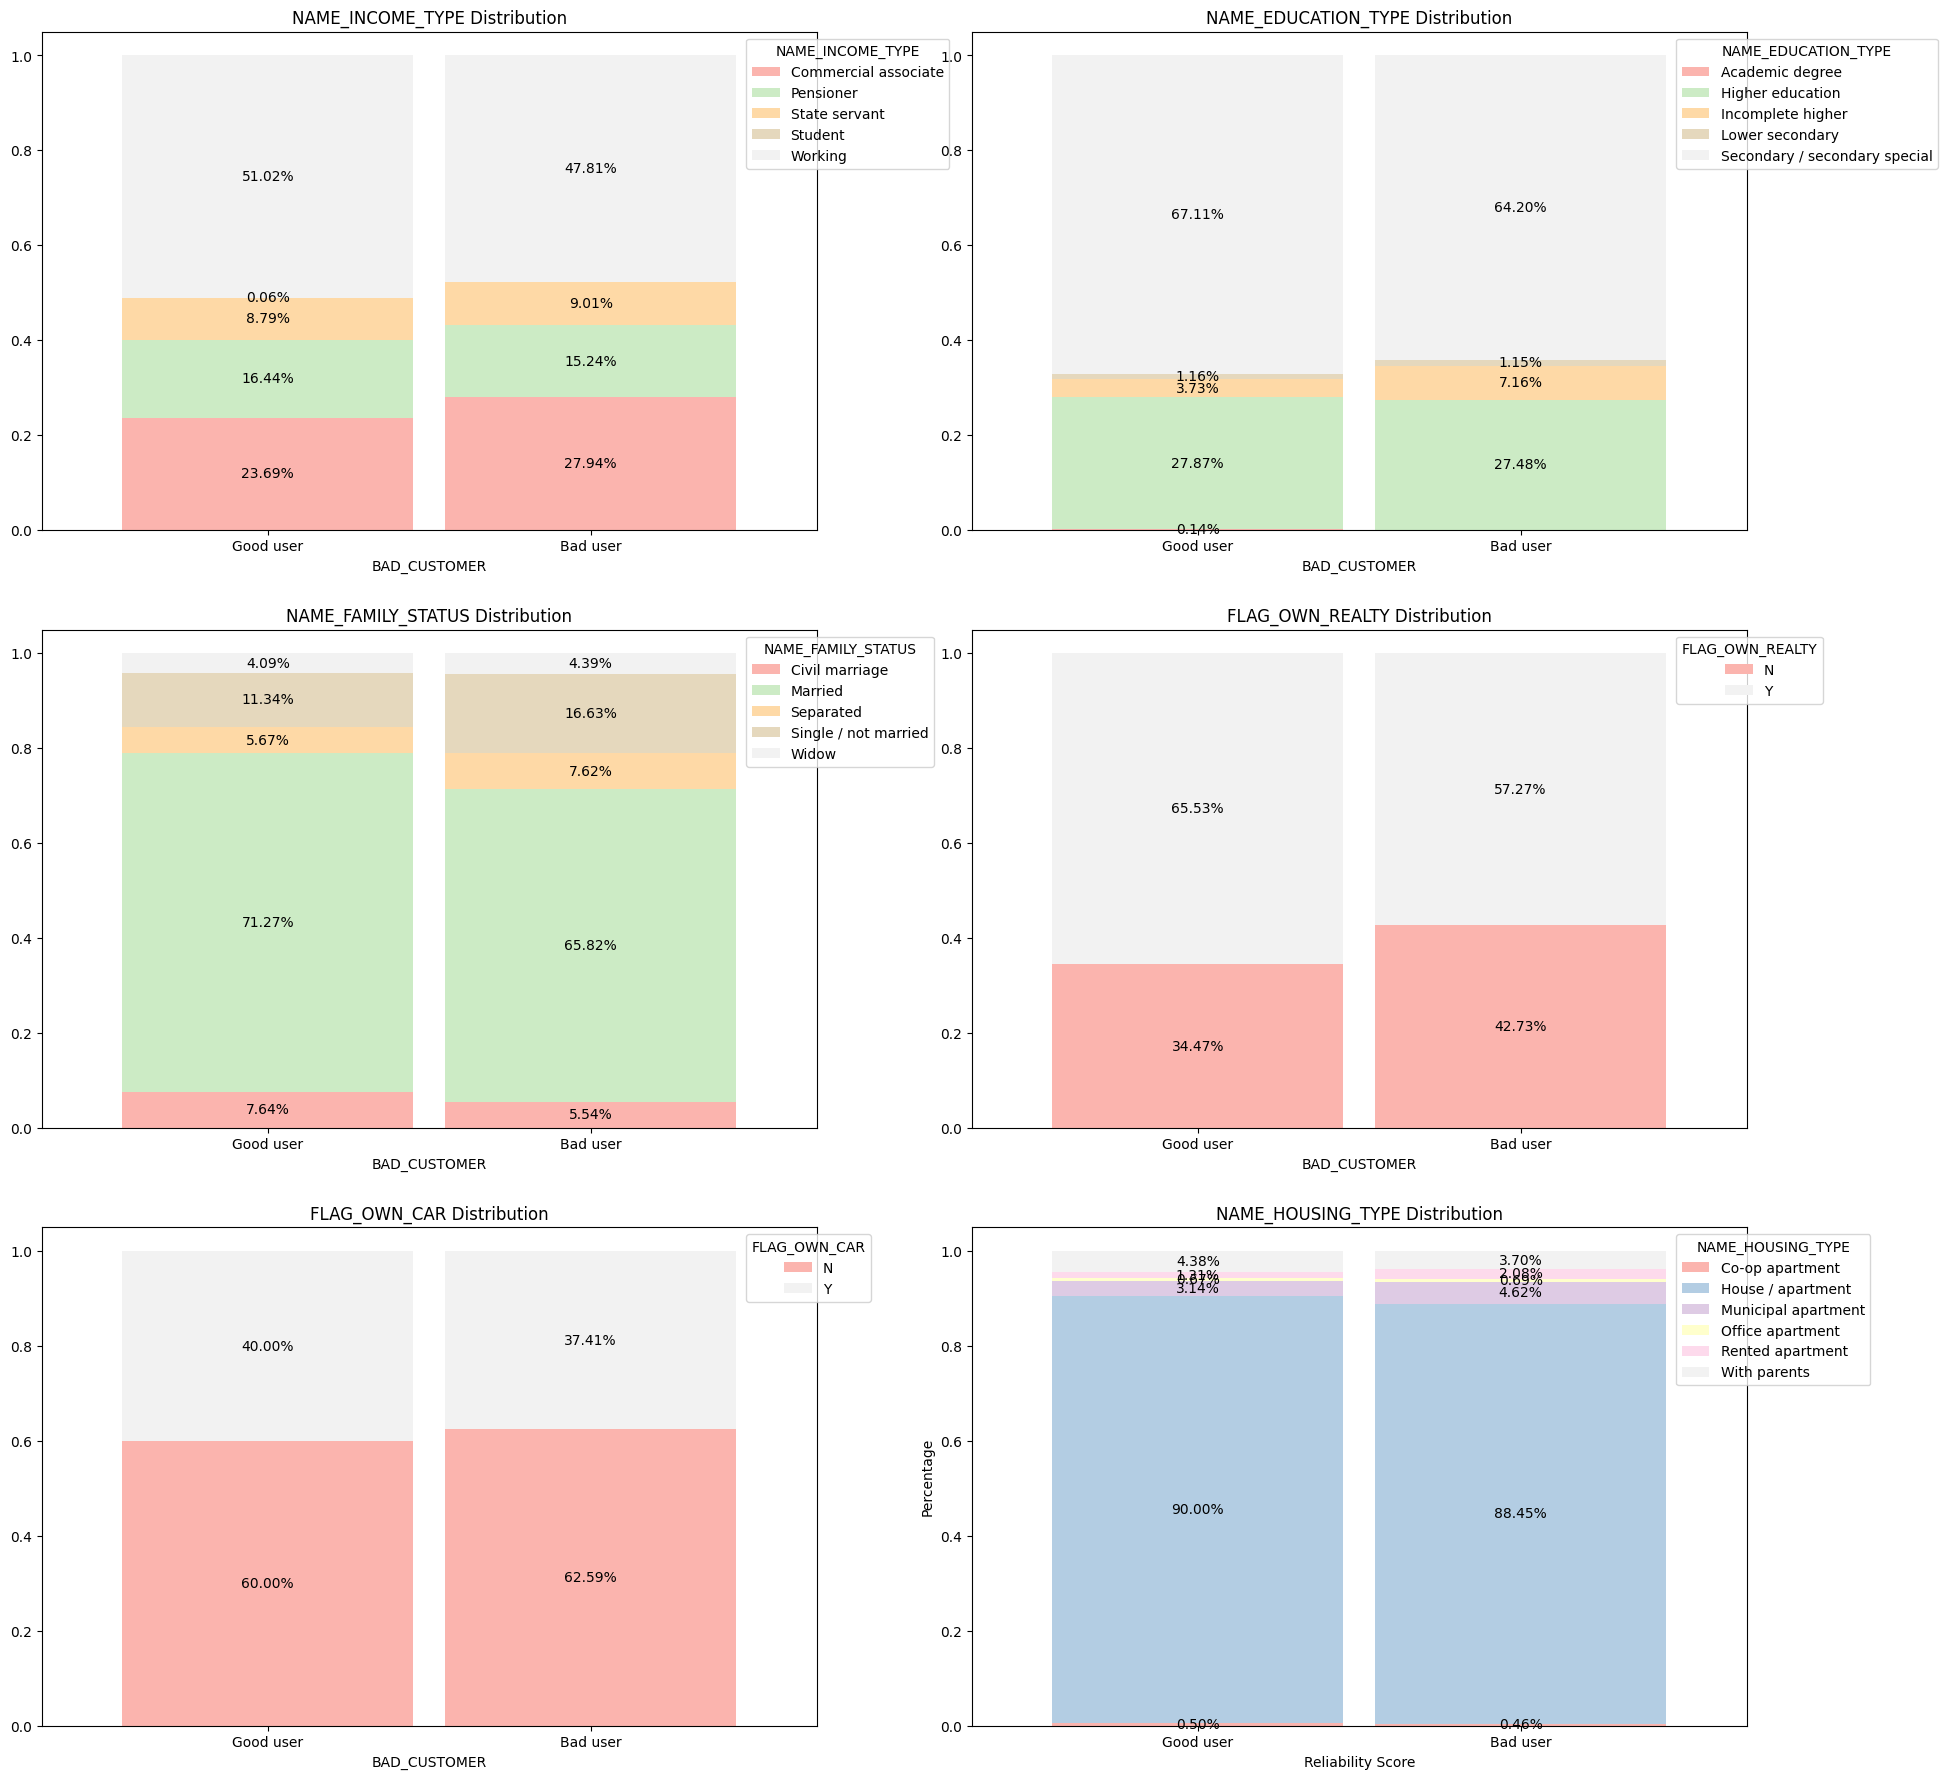

In [66]:
subplot = 0
axes = []
fig, axes = plt.subplots(3,2, figsize=(22, 22))
labels = ("Good user", "Bad user")
x = np.arange(len(labels))
for column in columns_of_interest:
    cross_tab = pd.crosstab(approved_applications['BAD_CUSTOMER'], approved_applications[column])
    cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    cross_tab_plot = cross_tab.plot(kind='bar', stacked=True, width=0.9, ax=axes[int(subplot/2)][subplot%2], colormap='Pastel1')
    axes[int(subplot/2)][subplot%2].legend(title=column, bbox_to_anchor=(0.9, 1), loc='upper left')
    show_percentage(cross_tab_plot, cross_tab)
    axes[int(subplot/2)][subplot%2].set_xticks(x, labels, rotation='horizontal')
    plt.xlabel('Reliability Score')
    plt.ylabel('Percentage')
    axes[int(subplot/2)][subplot%2].set_title(column + ' Distribution')
    subplot += 1
plt.show() 

In [67]:
for column in columns_of_interest:
    chi_squared_test(approved_applications, column, "BAD_CUSTOMER")

Chi2: 4.70, p-value: 0.32
Features NAME_INCOME_TYPE and BAD_CUSTOMER are independent
Chi2: 14.02, p-value: 0.01
Features NAME_EDUCATION_TYPE and BAD_CUSTOMER are dependent
Chi2: 17.25, p-value: 0.00
Features NAME_FAMILY_STATUS and BAD_CUSTOMER are dependent
Chi2: 12.24, p-value: 0.00
Features FLAG_OWN_REALTY and BAD_CUSTOMER are dependent
Chi2: 1.06, p-value: 0.30
Features FLAG_OWN_CAR and BAD_CUSTOMER are independent
Chi2: 5.26, p-value: 0.39
Features NAME_HOUSING_TYPE and BAD_CUSTOMER are independent


In [68]:
pd.crosstab(approved_applications['BAD_CUSTOMER'], approved_applications["NAME_EDUCATION_TYPE"][approved_applications["NAME_EDUCATION_TYPE"].isin(['Academic degree'])])

NAME_EDUCATION_TYPE,Academic degree
BAD_CUSTOMER,
0,18


From barplots above, we can see that the distribution of features apparently does not change significantly with the creditworthiness of the clients. However, we can see that the distribution of the **NAME_EDUCATION_TYPE** feature changes significantly with the creditworthiness of the clients. In particular, we can see that the percentage of clients with a higher education level and the percentage of clients with a higher family status increases with the creditworthiness of the clients. This means that this feature can be relevant for the analysis. Moreover, observing the second set of barplots, where we analyze directly the distribution of features for bad and good clients, we can see that also **NAME_FAMILY_STATUS** and **FLAG_OWN_REALTY** features are relevant for the analysis, since the distribution of these features changes significantly with the creditworthiness of the clients.
Analyticaly according to the chi-squared analysis, dependent features with the target variables are **NAME_EDUCATION_TYPE**, **NAME_FAMILY_STATUS** and **FLAG_OWN_REALTY** with P-value of the chi-squared analysis is lower than 0.05 for these variables.
A particular consideration must be done for features **NAME_INCOME_TYPE** and **NAME_HOUSING_TYPE**: the P-value of the chi-squared analysis is higher than 0.05, but the features are still relevant for the analysis, since they can have a significant impact on the creditworthiness of the clients.
We dedice to keep **NAME_INCOME_TYPE**, and discard **NAME_HOUSING_TYPE**, since the first one is considered more relevant.
Another interesting thing is that clients with an academic degree are more likely to be good clients (100% in the dataset).

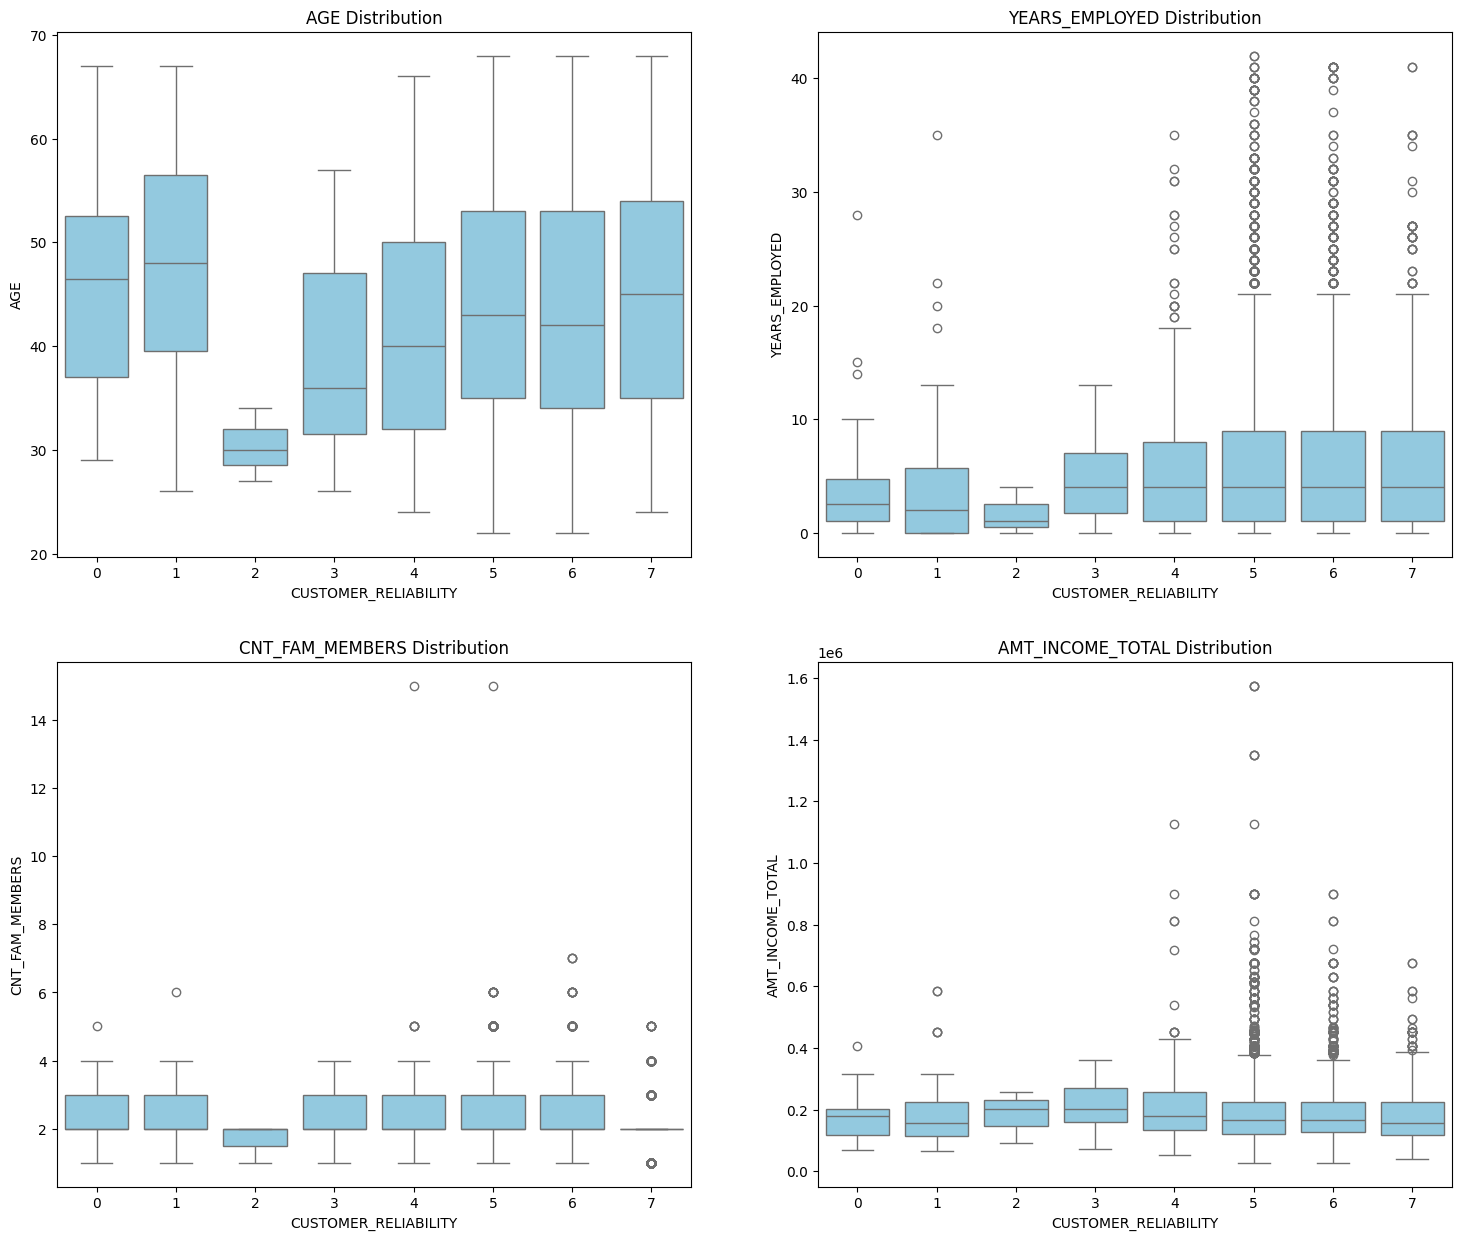

In [69]:
numerical_columns = ['AGE', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL']
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
for i, column in enumerate(numerical_columns):
    sns.boxplot(x='CUSTOMER_RELIABILITY', y=column, data=approved_applications, ax=axes[int(i/2)][i%2], color='skyblue')
    axes[int(i/2)][i%2].set_title(column + ' Distribution')
plt.show()

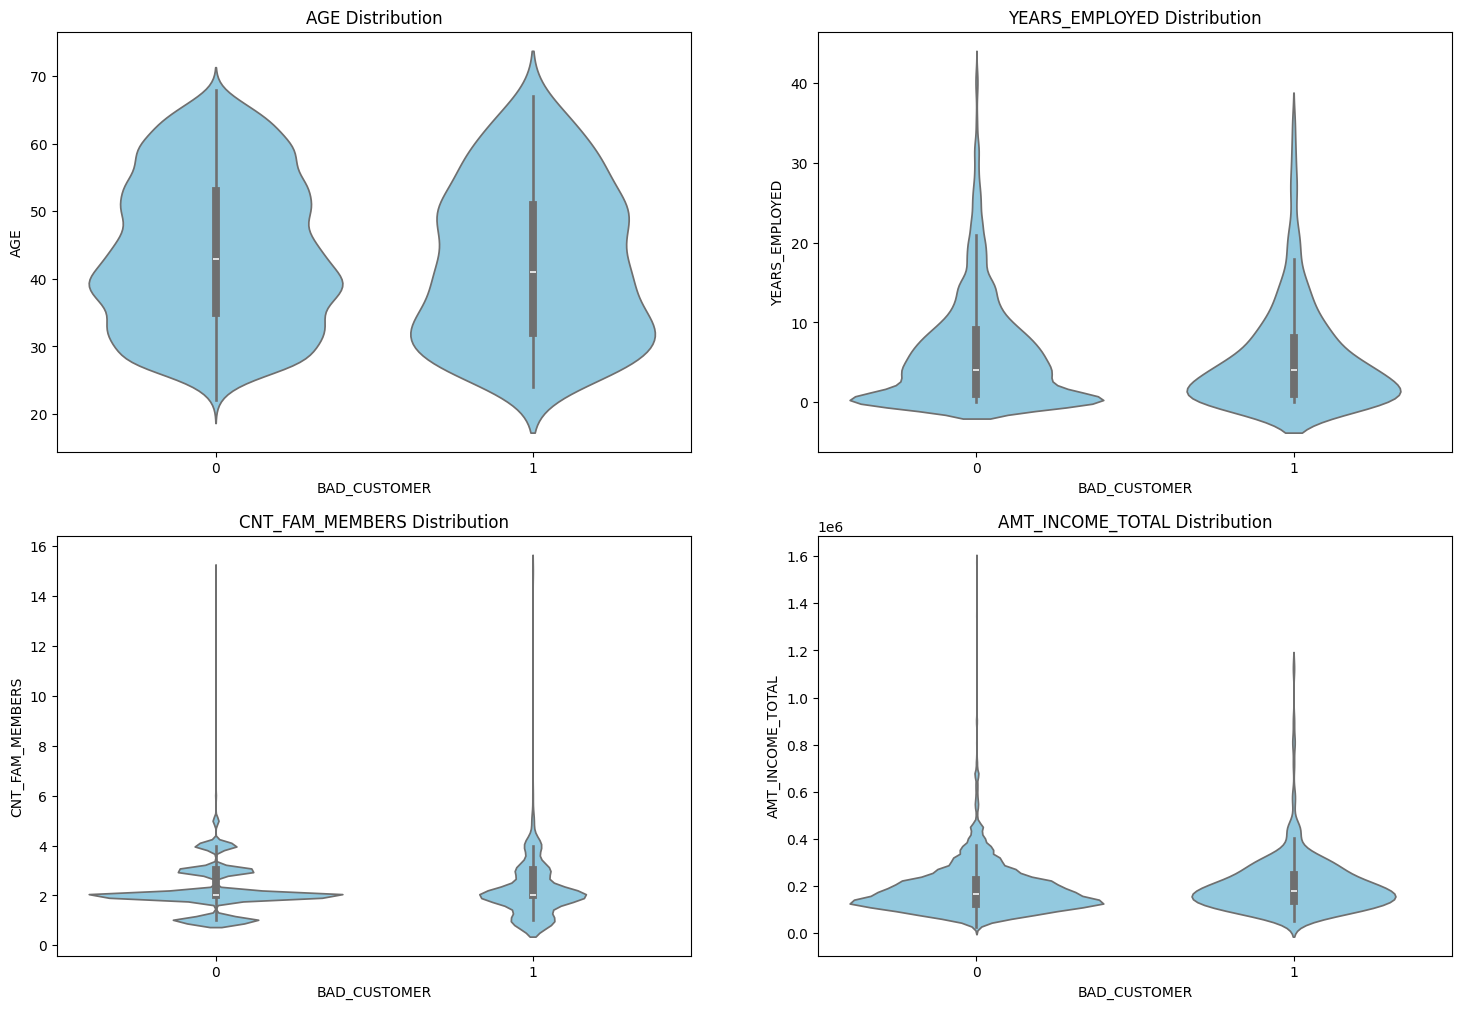

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i, column in enumerate(numerical_columns):
    sns.violinplot(x='BAD_CUSTOMER', y=column, data=approved_applications, ax=axes[int(i/2)][i%2], color='skyblue')
    axes[int(i/2)][i%2].set_title(column + ' Distribution')

In [71]:
for column in numerical_columns:
    chi_squared_test(approved_applications, column, "BAD_CUSTOMER")

Chi2: 93.61, p-value: 0.00
Features AGE and BAD_CUSTOMER are dependent
Chi2: 51.26, p-value: 0.15
Features YEARS_EMPLOYED and BAD_CUSTOMER are independent
Chi2: 17.89, p-value: 0.01
Features CNT_FAM_MEMBERS and BAD_CUSTOMER are dependent
Chi2: 287.27, p-value: 0.00
Features AMT_INCOME_TOTAL and BAD_CUSTOMER are dependent


From boxplot it is still difficult to understand the relationship between the features and the creditworthiness of the clients.
However, observing the violin plots, we can see that the distribution of the **AMT_INCOME_TOTAL** feature changes significantly with the creditworthiness of the clients. In particular, we can see that the distribution of the **AMT_INCOME_TOTAL** feature is wider for good clients, which means that the income of the clients can be relevant for the analysis. We can then use this feature to predict the creditworthiness of the clients.
Also **AGE** seems to be relevant, with a median value higher for good clients, and a wider distribution for good clients.
Finally **CNT_FAM_MEMBERS** has a different distribution for good and bad clients, which means that this feature can be relevant for the analysis.
The chi-squared analysis confirms that **AMT_INCOME_TOTAL**, **AGE** and **CNT_FAM_MEMBERS** are relevant for the analysis, with P-value of the chi-squared analysis lower than 0.05 for these variables. 

## Preprocessing

In order to train the model, we need to preprocess the data. We can start by encoding the categorical features of the dataframe. We can then split the dataframe into a training set and a test set, in order to train the model and then test its performance. We can then scale the features of the dataframe, in order to make the model more robust to the different scales of the features. We can then train the model and test its performance on the test set.
We encode the categorical features of the dataframe using the OneHotEncoder, which creates a binary column for each category and returns a sparse matrix or dense array. For binary (two-category) features, we can use the OrdinalEncoder, which returns a dense array of 0s-1s.
Then we prepare numerical features for scaling. We will use the StandardScaler when trying the Logistic Regression model, and the MinMaxScaler when trying a simple Neural Network model. For Random Forest we will not scale the features, since this model is not sensitive to the scale of the features.
We also remove features that are not relevant for the analysis, as we have seen from the correlation analysis.

In [72]:

columns_to_ordinal_encode = ['FLAG_OWN_REALTY']
columns_to_one_hot_encode = ['NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']
columns_to_scale = ['AMT_INCOME_TOTAL', 'AGE', 'CNT_FAM_MEMBERS']

X = approved_applications.drop(columns=['ID', "FLAG_OWN_CAR", 'CUSTOMER_RELIABILITY', 
                                        'BAD_CUSTOMER', 'FLAG_MOBIL', "NAME_HOUSING_TYPE", "YEARS_EMPLOYED",
                                        'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'])
y = approved_applications['BAD_CUSTOMER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

column_transformer = ColumnTransformer([
    ('ORDINAL', OrdinalEncoder( ), columns_to_ordinal_encode),
    ('OHE', OneHotEncoder(sparse_output=False), columns_to_one_hot_encode),
    ], 
    remainder='passthrough')

column_transformer.set_output(transform='pandas')
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)
X_train = X_train.astype('int64')
X_test = X_test.astype('int64')


In [73]:
rename_column_without_prefix(X_train, X_test, prefix="remainder__")
rename_column_without_prefix(X_train, X_test, prefix="ORDINAL__")
rename_column_without_prefix(X_train, X_test, prefix="OHE__NAME_")

Let see the correlation matrix of the dataframe after the preprocessing:

Text(0.5, 1.0, 'Correlation Matrix')

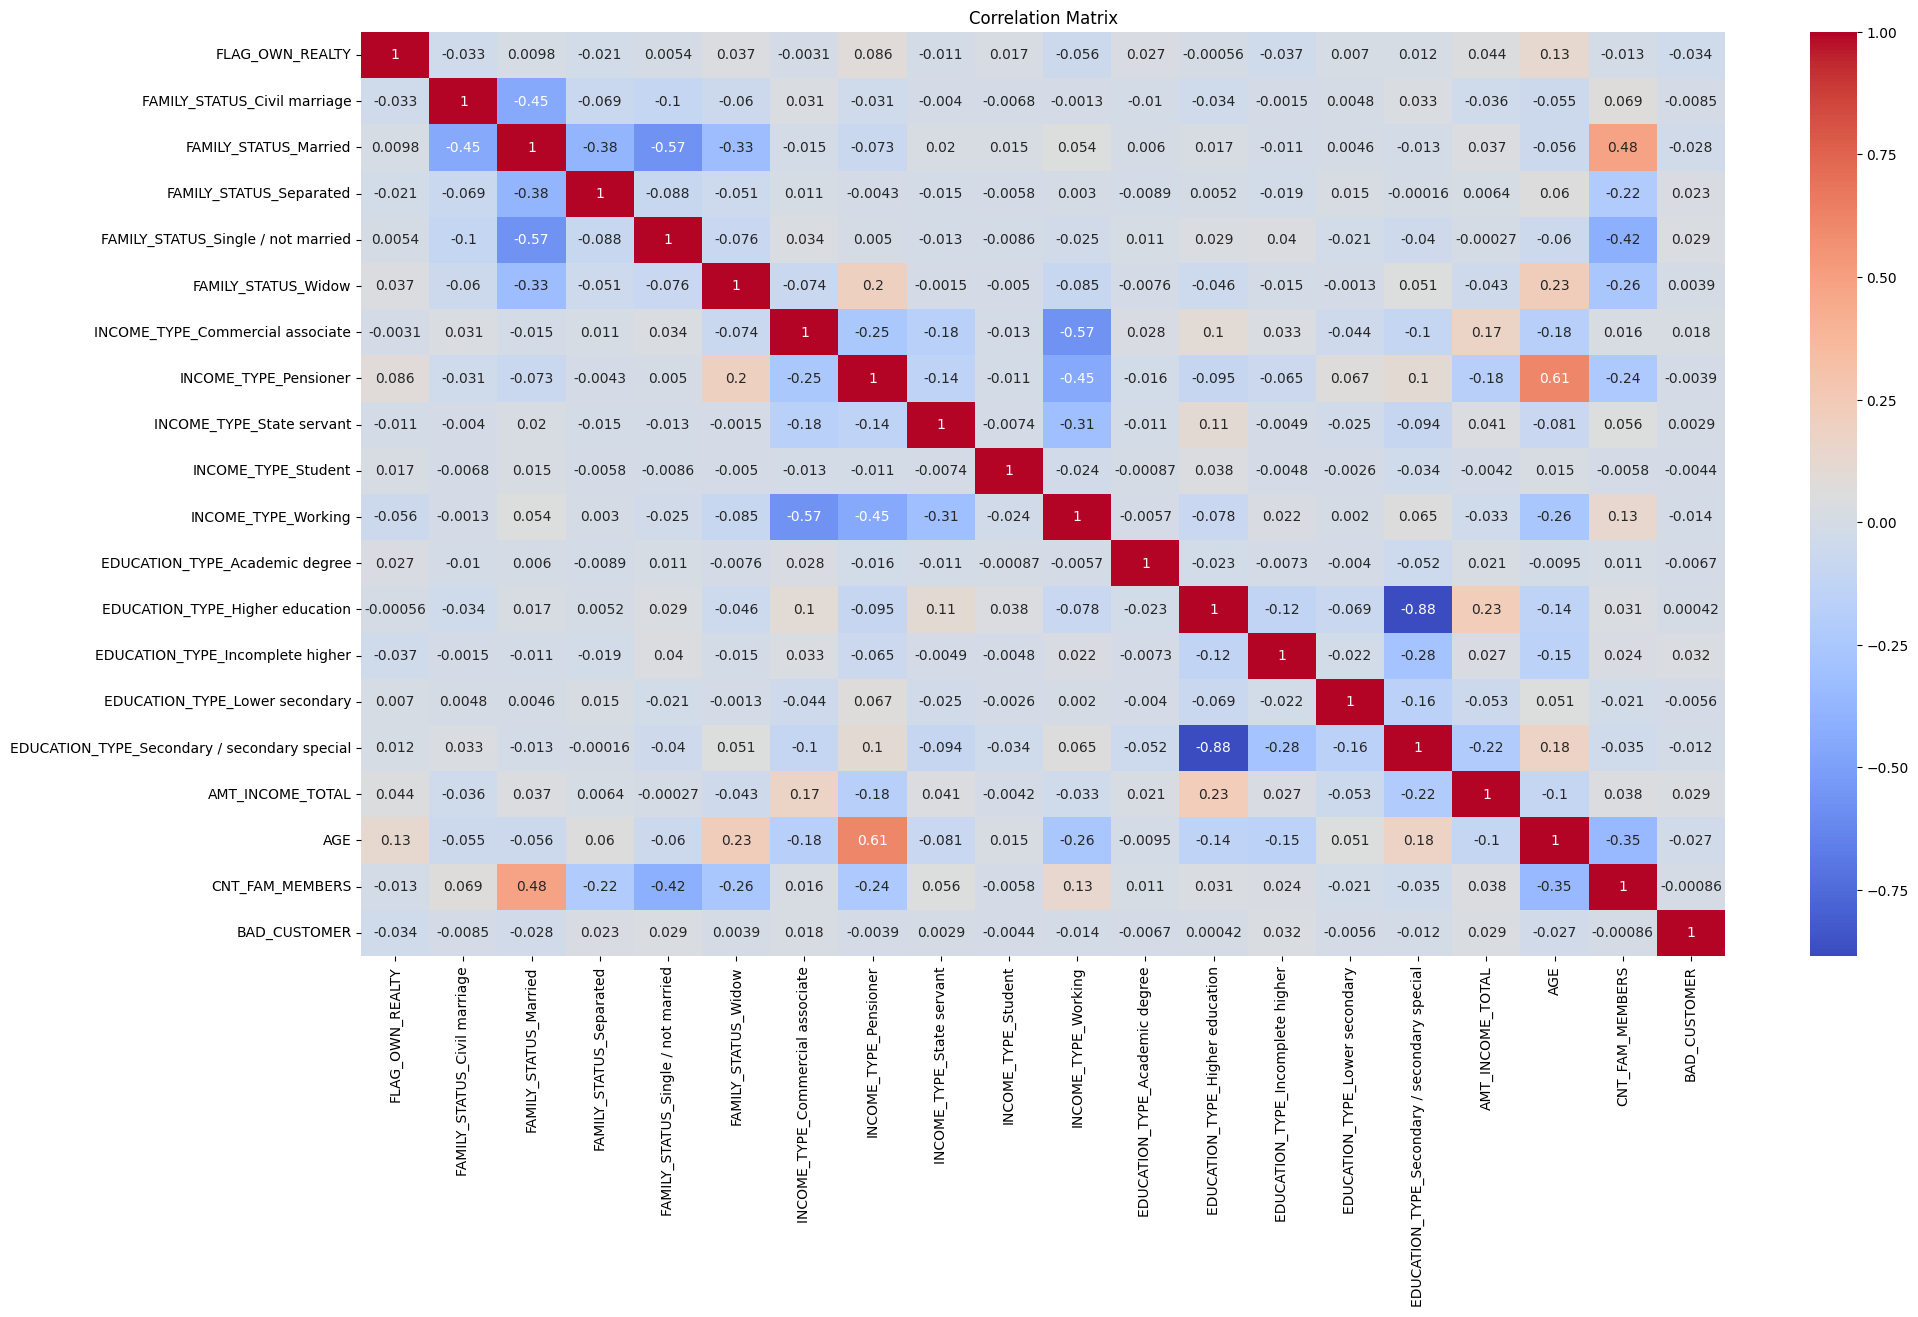

In [74]:
temp_df = X_train.join(y_train)
corr = temp_df.corr()
_, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(corr, annot=True, ax=ax, cmap="coolwarm")
plt.title("Correlation Matrix")

We can notice that the correlation matrix is not very informative, since the features are not correlated with the creditworthiness of the clients. This means that the features are not linearly related to the creditworthiness of the clients, and we need to use a more complex model to predict the creditworthiness of the clients.
We decide to remove some encoded features from the dataframe, and to keep only the ones you can see in the code cell below. 


In [75]:
X_train_rf = X_train[["FLAG_OWN_REALTY", "AGE", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS", "INCOME_TYPE_Pensioner", "INCOME_TYPE_Student", "EDUCATION_TYPE_Academic degree", "FAMILY_STATUS_Married", "FAMILY_STATUS_Single / not married", "EDUCATION_TYPE_Higher education"]]
X_test_rf  =  X_test[["FLAG_OWN_REALTY", "AGE", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS", "INCOME_TYPE_Pensioner", "INCOME_TYPE_Student", "EDUCATION_TYPE_Academic degree", "FAMILY_STATUS_Married", "FAMILY_STATUS_Single / not married", "EDUCATION_TYPE_Higher education"]]

## Model training and testing

Even if we observed from the correlation matrix that the features are not linearly related to the creditworthiness of the clients, we can still try to train a Logistic Regression model to predict the creditworthiness of the clients, and then we will handle more complex algorithms. We can then test the performance of the model on the test set, in order to understand if the model is able to predict the creditworthiness of the clients, and then exploit the confusion matrix to understand the performance of the model.
Before training the model, we need to apply the standard scaling to the features of the dataframe. 

In [76]:
std_scaler_transformer = ColumnTransformer([
    ('STD_SCALER', StandardScaler(), columns_to_scale)
    ], 
    remainder='passthrough')
std_scaler_transformer.set_output(transform='pandas')
X_train_std = std_scaler_transformer.fit_transform(X_train_rf)
X_test_std = std_scaler_transformer.transform(X_test_rf)
X_train_std = X_train_std.astype('int64')
X_test_std = X_test_std.astype('int64')
rename_column_without_prefix(X_train_std, X_test_std, prefix="remainder__")
X_train_std.head()


,STD_SCALER__AMT_INCOME_TOTAL,STD_SCALER__AGE,STD_SCALER__CNT_FAM_MEMBERS,FLAG_OWN_REALTY,INCOME_TYPE_Pensioner,INCOME_TYPE_Student,EDUCATION_TYPE_Academic degree,FAMILY_STATUS_Married,FAMILY_STATUS_Single / not married,EDUCATION_TYPE_Higher education
11443,0,0,0,1,0,0,0,1,0,0
9752,0,1,0,1,0,0,0,1,0,1
5632,0,0,1,1,0,0,0,0,0,0
7700,0,1,0,1,1,0,0,1,0,0
9208,0,0,0,1,0,0,0,1,0,0


We the analyse how the target variable is distributed. We can see that the dataset is really very unbalanced, and we need to take this into account when we will train the model.
We prepare the training set in two different ways: the first using the SMOTE technique to balance the dataset, applying an oversampling of the minority class, and the second using a random undersampling technique to balance the dataset, applying an undersampling of the majority class.

In [77]:
print(approved_applications["BAD_CUSTOMER"].value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

BAD_CUSTOMER
0    12720
1      433
Name: count, dtype: int64
BAD_CUSTOMER
0    10176
1      346
Name: count, dtype: int64
BAD_CUSTOMER
0    2544
1      87
Name: count, dtype: int64


In [78]:
smote = SMOTE(sampling_strategy=0.7, random_state=RANDOM_STATE)
X_train_std_smt, y_train_smote = smote.fit_resample(X_train_std, y_train)
print("SMOTE: ", y_train_smote.value_counts())

rus = RandomUnderSampler(sampling_strategy=0.75, random_state=RANDOM_STATE)
X_train_stdrus, y_train_rus = rus.fit_resample(X_train_std, y_train)
print("Undersampling: ", y_train_rus.value_counts())

models = {}


SMOTE:  BAD_CUSTOMER
0    10176
1     7123
Name: count, dtype: int64
Undersampling:  BAD_CUSTOMER
0    461
1    346
Name: count, dtype: int64


### Model 1: Logistic Regression with SMOTE
The first model we train is a Logistic Regression model, exploiting the SMOTE technique (Synthetic Minority Over-sampling Technique) to balance the dataset. We decided to adopt a sample strategy of 0.7 for the minority class, which means that we will create a number of samples for the minority class equal to 70% of the number of samples of the majority class.
Let see how this model performs:

Train Set Accuracy:  0.58
              precision    recall  f1-score   support

           0       0.66      0.58      0.62     10176
           1       0.49      0.57      0.52      7123

    accuracy                           0.58     17299
   macro avg       0.57      0.58      0.57     17299
weighted avg       0.59      0.58      0.58     17299

--------------------
Test Set Accuracy:  0.58
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      2544
           1       0.04      0.51      0.07        87

    accuracy                           0.58      2631
   macro avg       0.51      0.54      0.40      2631
weighted avg       0.94      0.58      0.70      2631



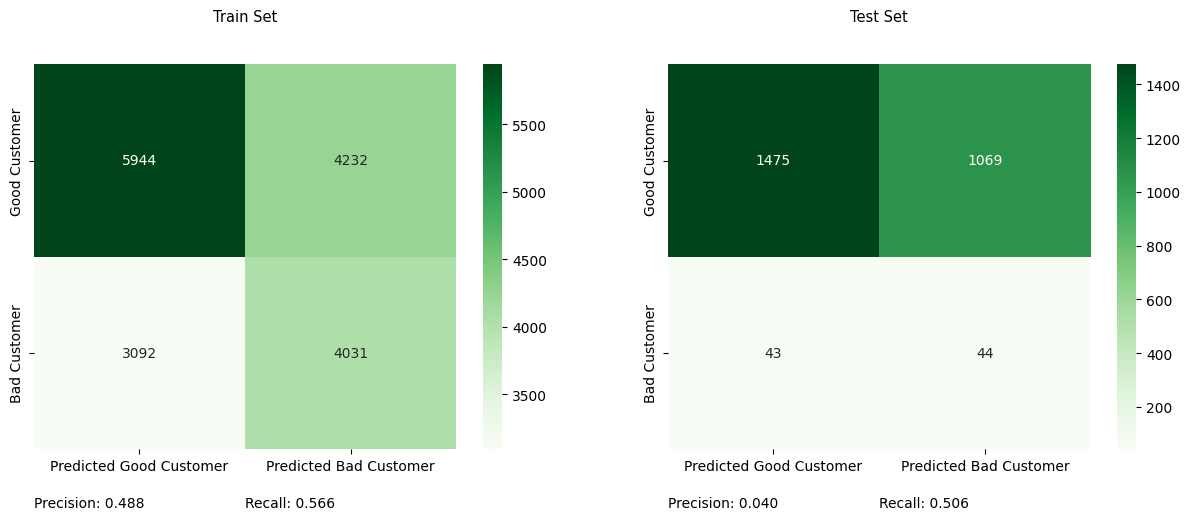

In [79]:
log_reg_smt, report_train_smt, report_test_smt = perform_logistic_regression(X_train_std_smt, y_train_smote, X_test_std, y_test, class_weight='balanced')

In [109]:
precision_good_cl, recall_good_cl, precision_bad_cl, recall_bad_cl = get_info_from_classification_report(report_train_smt)
precision_good_cl_test, recall_good_cl_test, precision_bad_cl_test, recall_bad_cl_test = get_info_from_classification_report(report_test_smt)
models["Log-Reg SMOTE"] = {
                            "Train_accuracy": get_accuracy_from_classification_report(report_train_smt), 
                            "Train_precision_good_cl": precision_good_cl,
                            "Train_recall_good_cl": recall_good_cl,
                            "Train_precision_bad_cl": precision_bad_cl,
                            "Train_recall_bad_cl": recall_bad_cl,
                            "Test_accuracy": get_accuracy_from_classification_report(report_test_smt), 
                            "Test_precision_good_cl": precision_good_cl_test,
                            "Test_recall_good_cl": recall_good_cl_test,
                            "Test_precision_bad_cl": precision_bad_cl_test,
                            "Test_recall_bad_cl": recall_bad_cl_test                            
                           }

On the training set we can notice that the model has quite poor performance, with an accuracy of 0.58 both in the training and in the test set. This means that the model is not able to predict the creditworthiness of the clients. In particular, precision is very low for the minority class, and we also missclassify a lot of good clients. Considering how the dataset is unbalanced, the recall of bad clients, is quite good, and we can take that as a target for our purpose.

### Model 2: Logistic Regression with Random Undersampling

The second model we train is a Logistic Regression model, exploiting the Random Undersampling technique to balance the dataset. We decided to adopt a sample strategy of 0.75 for the majority class, which means that we will create a number of samples for the majority class equal to 75% of the number of samples of the minority class.
Let see how this model performs, and if there is any improvement with respect to the previous model:

Train Set Accuracy:  0.6
              precision    recall  f1-score   support

           0       0.60      0.91      0.72       461
           1       0.60      0.18      0.28       346

    accuracy                           0.60       807
   macro avg       0.60      0.55      0.50       807
weighted avg       0.60      0.60      0.53       807

--------------------
Test Set Accuracy:  0.87
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2544
           1       0.06      0.18      0.09        87

    accuracy                           0.87      2631
   macro avg       0.51      0.54      0.51      2631
weighted avg       0.94      0.87      0.90      2631



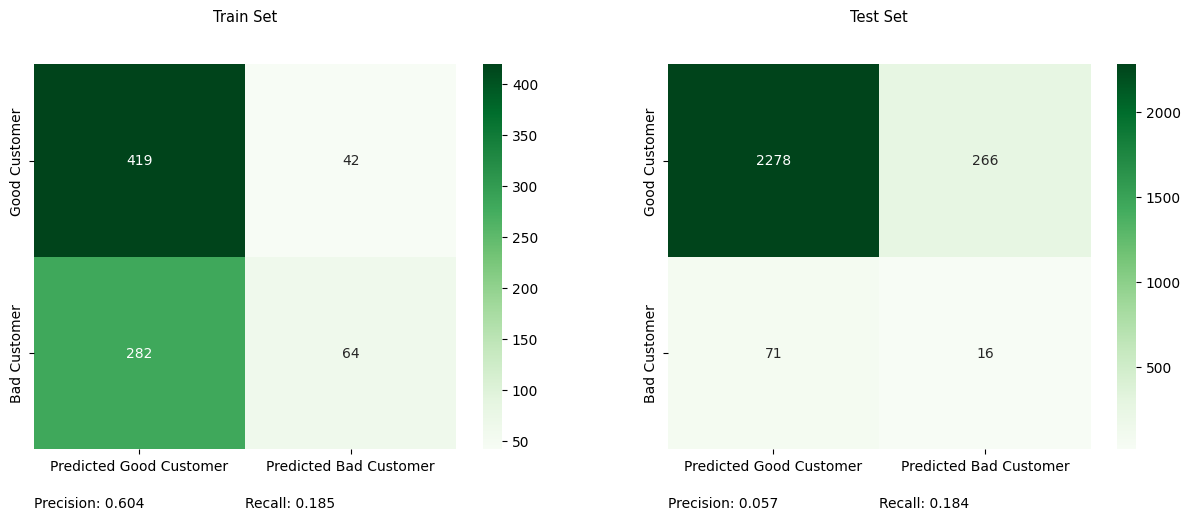

In [81]:
log_reg_ru, report_train_ru, report_test_ru = perform_logistic_regression(X_train_stdrus, y_train_rus, X_test_std, y_test)

In [110]:
precision_good_cl, recall_good_cl, precision_bad_cl, recall_bad_cl = get_info_from_classification_report(report_train_ru)
precision_good_cl_test, recall_good_cl_test, precision_bad_cl_test, recall_bad_cl_test = get_info_from_classification_report(report_test_ru)
models["Log-Reg Under"] = {"Train_accuracy": get_accuracy_from_classification_report(report_train_ru), 
                            "Train_precision_good_cl": precision_good_cl,
                            "Train_recall_good_cl": recall_good_cl,
                            "Train_precision_bad_cl": precision_bad_cl,
                            "Train_recall_bad_cl": recall_bad_cl,
                            "Test_accuracy": get_accuracy_from_classification_report(report_test_ru), 
                            "Test_precision_good_cl": precision_good_cl_test,
                            "Test_recall_good_cl": recall_good_cl_test,
                            "Test_precision_bad_cl": precision_bad_cl_test,
                            "Test_recall_bad_cl": recall_bad_cl_test
                           }

In [83]:
smote = SMOTE(sampling_strategy=0.3, random_state=RANDOM_STATE)
X_train_std_smt03, y_train_smt03 = smote.fit_resample(X_train_std, y_train)
under = RandomUnderSampler(sampling_strategy=.3, random_state=RANDOM_STATE)
X_train_std_smt03rus, y_train_smt03rus = under.fit_resample(X_train_std_smt03, y_train_smt03)

print(y_train_smt03rus.value_counts())
print(X_train_std_smt03rus.shape)

BAD_CUSTOMER
0    10173
1     3052
Name: count, dtype: int64
(13225, 10)


Train Set Accuracy:  0.62
              precision    recall  f1-score   support

           0       0.84      0.62      0.71     10173
           1       0.33      0.62      0.43      3052

    accuracy                           0.62     13225
   macro avg       0.59      0.62      0.57     13225
weighted avg       0.72      0.62      0.65     13225

--------------------
Test Set Accuracy:  0.61
              precision    recall  f1-score   support

           0       0.97      0.61      0.75      2544
           1       0.04      0.47      0.07        87

    accuracy                           0.61      2631
   macro avg       0.51      0.54      0.41      2631
weighted avg       0.94      0.61      0.73      2631



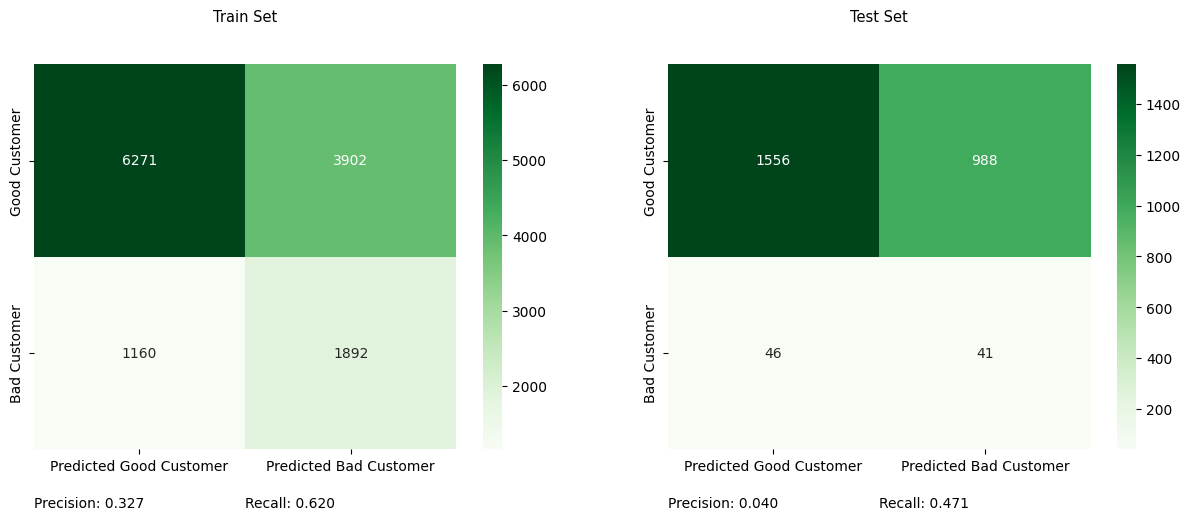

In [101]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_std_smt03rus_poly = poly.fit_transform(X_train_std_smt03rus)
X_test_std_poly = poly.transform(X_test_std)
log_reg_poly, train_report, test_report = perform_logistic_regression(X_train_std_smt03rus_poly, y_train_smt03rus, X_test_std_poly, y_test, class_weight='balanced', threshold=0.5)

In [111]:
precision_good_cl, recall_good_cl, precision_bad_cl, recall_bad_cl = get_info_from_classification_report(train_report)
precision_good_cl_test, recall_good_cl_test, precision_bad_cl_test, recall_bad_cl_test = get_info_from_classification_report(test_report)
models["Poly-Log-Reg"] = {"Train_accuracy": get_accuracy_from_classification_report(train_report), 
                            "Train_precision_good_cl": precision_good_cl,
                            "Train_recall_good_cl": recall_good_cl,
                            "Train_precision_bad_cl": precision_bad_cl,
                            "Train_recall_bad_cl": recall_bad_cl,
                            "Test_accuracy": get_accuracy_from_classification_report(test_report), 
                            "Test_precision_good_cl": precision_good_cl_test,
                            "Test_recall_good_cl": recall_good_cl_test,
                            "Test_precision_bad_cl": precision_bad_cl_test,
                            "Test_recall_bad_cl": recall_bad_cl_test
                            
    }

In [112]:
models_df = pd.DataFrame(models).T
models_df

,Train_accuracy,Train_precision_good_cl,Train_recall_good_cl,Train_precision_bad_cl,Train_recall_bad_cl,Test_accuracy,Test_precision_good_cl,Test_recall_good_cl,Test_precision_bad_cl,Test_recall_bad_cl
Log-Reg SMOTE,0.58,0.66,0.58,0.49,0.57,0.58,0.97,0.58,0.04,0.51
Log-Reg Under,0.60,0.60,0.91,0.60,0.18,0.87,0.97,0.90,0.06,0.18
Poly-Log-Reg,0.62,0.84,0.62,0.33,0.62,0.61,0.97,0.61,0.04,0.47


In [99]:
X_train_rf.head()

,FLAG_OWN_REALTY,AGE,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,INCOME_TYPE_Pensioner,INCOME_TYPE_Student,EDUCATION_TYPE_Academic degree,FAMILY_STATUS_Married,FAMILY_STATUS_Single / not married,EDUCATION_TYPE_Higher education
11443,1,53,90000,2,0,0,0,1,0,0
9752,1,55,157500,2,0,0,0,1,0,1
5632,1,37,189000,4,0,0,0,0,0,0
7700,1,60,90000,2,1,0,0,1,0,0
9208,1,36,157500,3,0,0,0,1,0,0


In [86]:
rnd_forest = BalancedRandomForestClassifier(random_state=RANDOM_STATE,
    replacement=True, bootstrap=True, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt'],
    'sampling_strategy': [0.5, 0.75, 1.]
}
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
    grid_search_1 = GridSearchCV(rnd_forest, param_grid, cv=cv,  n_jobs=-1)
grid_search_1.fit(X_train_rf, y_train)

print(grid_search_1.best_params_)


{'max_features': 'sqrt', 'n_estimators': 500, 'sampling_strategy': 0.5}


In [87]:
best_rnd_forest = grid_search_1.best_estimator_
best_rnd_forest.fit(X_train_rf, y_train)
y_pred_train = np.where(best_rnd_forest.predict_proba(X_train_rf)[:,1]>0.55, 1, 0)
y_pred = np.where(best_rnd_forest.predict_proba(X_test_rf)[:,1]>0.55, 1, 0)
accuracy_score(y_test, y_pred)

0.895096921322691

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     10176
           1       0.27      0.99      0.43       346

    accuracy                           0.91     10522
   macro avg       0.64      0.95      0.69     10522
weighted avg       0.98      0.91      0.94     10522

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2544
           1       0.16      0.51      0.24        87

    accuracy                           0.90      2631
   macro avg       0.57      0.71      0.59      2631
weighted avg       0.95      0.90      0.92      2631



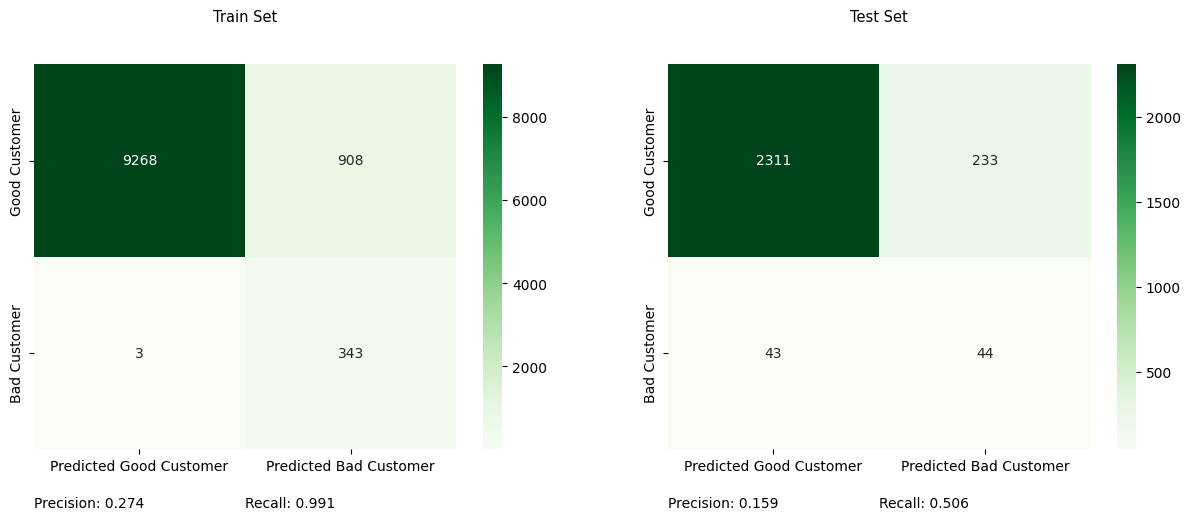

In [88]:
report_train_rf = classification_report(y_train, y_pred_train)
report_test_rf = classification_report(y_test, y_pred)
print(report_train_rf)
print(report_test_rf)
print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [89]:
balanced_model = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(), replacement=True, random_state=RANDOM_STATE, n_jobs=-1)
param_grid = {
    'n_estimators': [200, 500, 750],
    'max_samples': [0.75, 1.],
    'max_features': [0.5, 0.75, 1.]
}
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
    grid_search = GridSearchCV(balanced_model, param_grid, cv=cv, n_jobs=-1)

grid_search.fit(X_train_rf, y_train)
print(grid_search.best_params_)


{'max_features': 0.75, 'max_samples': 1.0, 'n_estimators': 750}


              precision    recall  f1-score   support

           0       1.00      0.90      0.95     10176
           1       0.24      0.96      0.39       346

    accuracy                           0.90     10522
   macro avg       0.62      0.93      0.67     10522
weighted avg       0.97      0.90      0.93     10522

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2544
           1       0.14      0.51      0.22        87

    accuracy                           0.88      2631
   macro avg       0.56      0.70      0.58      2631
weighted avg       0.95      0.88      0.91      2631



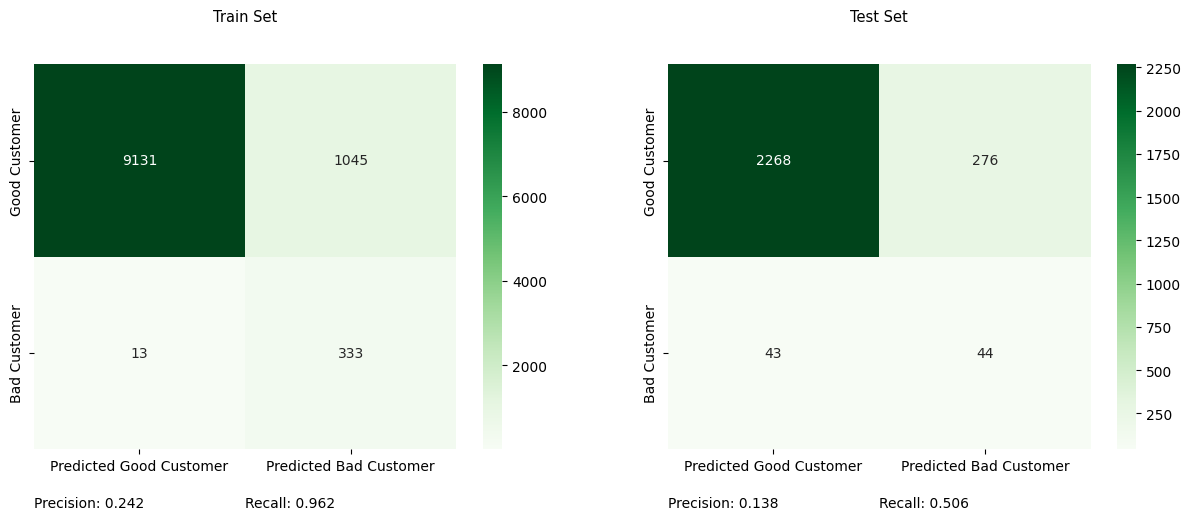

In [90]:
best_balanced_model = grid_search.best_estimator_
best_balanced_model.fit(X_train_rf, y_train)

y_pred_train = np.where(best_balanced_model.predict_proba(X_train_rf)[:,1]>0.55, 1, 0)
y_pred = np.where(best_balanced_model.predict_proba(X_test_rf)[:,1]>0.55, 1, 0)
accuracy_score(y_test, y_pred)

report_train_bb = classification_report(y_train, y_pred_train)
report_test_bb = classification_report(y_test, y_pred)
print(report_train_bb)
print(report_test_bb)

print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [91]:
norm_transformer = ColumnTransformer([
    ('NORM', MinMaxScaler(), columns_to_scale)
    ], 
    remainder='passthrough')

norm_transformer.set_output(transform='pandas')
X_train_norm = norm_transformer.fit_transform(X_train_rf)
X_test_norm = norm_transformer.transform(X_test_rf)
rename_column_without_prefix(X_train_norm, X_test_norm, prefix="remainder__")
X_train_norm.head()

,NORM__AMT_INCOME_TOTAL,NORM__AGE,NORM__CNT_FAM_MEMBERS,FLAG_OWN_REALTY,INCOME_TYPE_Pensioner,INCOME_TYPE_Student,EDUCATION_TYPE_Academic degree,FAMILY_STATUS_Married,FAMILY_STATUS_Single / not married,EDUCATION_TYPE_Higher education
11443,0.040698,0.673913,0.071429,1,0,0,0,1,0,0
9752,0.084302,0.717391,0.071429,1,0,0,0,1,0,1
5632,0.104651,0.326087,0.214286,1,0,0,0,0,0,0
7700,0.040698,0.826087,0.071429,1,1,0,0,1,0,0
9208,0.084302,0.304348,0.142857,1,0,0,0,1,0,0


In [92]:
smote = SMOTE(sampling_strategy=0.3, random_state=RANDOM_STATE)
X_train_norm_smt03, y_train_norm_smt03 = smote.fit_resample(X_train_norm, y_train)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
X_train_norm_smt03rus, y_train_norm_smt03rus = under.fit_resample(X_train_norm_smt03, y_train_norm_smt03)

print(y_train_norm_smt03rus.value_counts())
print(X_train_norm_smt03rus.shape)


mlp = MLPClassifier(hidden_layer_sizes=(100, 150, 225), max_iter=1000, random_state=RANDOM_STATE)
mlp.fit(X_train_norm_smt03rus, y_train_norm_smt03rus)
y_pred = mlp.predict(X_test_norm)
accuracy_score(y_test, y_pred)


BAD_CUSTOMER
0    6104
1    3052
Name: count, dtype: int64
(9156, 10)


0.88749524895477

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6104
           1       0.82      0.74      0.78      3052

    accuracy                           0.86      9156
   macro avg       0.85      0.83      0.84      9156
weighted avg       0.86      0.86      0.86      9156

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2544
           1       0.11      0.36      0.17        87

    accuracy                           0.89      2631
   macro avg       0.55      0.63      0.56      2631
weighted avg       0.95      0.89      0.91      2631



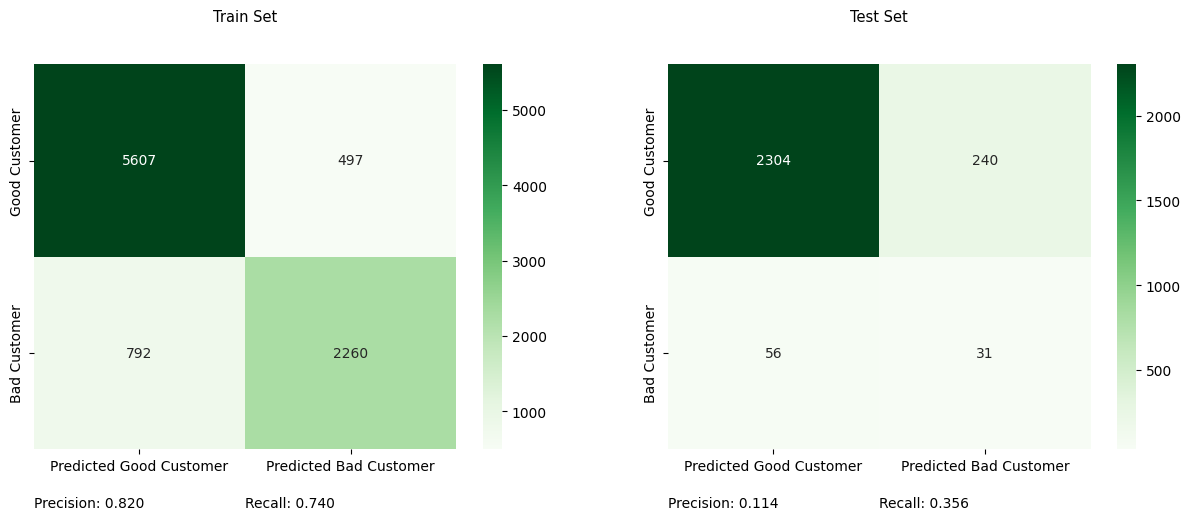

In [93]:
y_pred_train = np.where(mlp.predict_proba(X_train_norm_smt03rus)[:,1]>0.5, 1, 0)
y_pred = np.where(mlp.predict_proba(X_test_norm)[:,1]>0.5, 1, 0)
           

report_train_mlp = classification_report(y_train_norm_smt03rus, y_pred_train)
report_test_mlp = classification_report(y_test, y_pred)
print(report_train_mlp)
print(report_test_mlp)
print_train_test_confusion_matrix(train_matrix=confusion_matrix(y_train_norm_smt03rus, y_pred_train), test_matrix=confusion_matrix(y_test, y_pred), 
                           train_title="Train Set\n\n", test_title="Test Set\n\n")

In [94]:
y_pred = np.where(best_rnd_forest.predict_proba(X_test_rf)[:,1]>0.525, 1, 0)
correctly_classified_customers = approved_applications.loc[y_test[y_test == y_pred].index]

bad_client_classified = correctly_classified_customers[correctly_classified_customers['BAD_CUSTOMER'] == 1]

from sklearn.inspection import permutation_importance

result = permutation_importance(best_rnd_forest, X_test_rf, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)


Permutation Importance:  [ 1.04522995e-02  7.86773090e-03  1.85100722e-02  1.52033447e-02
  1.86240973e-03  0.00000000e+00 -3.80083618e-05 -5.43519574e-03
  6.00532117e-03  7.63968073e-03]


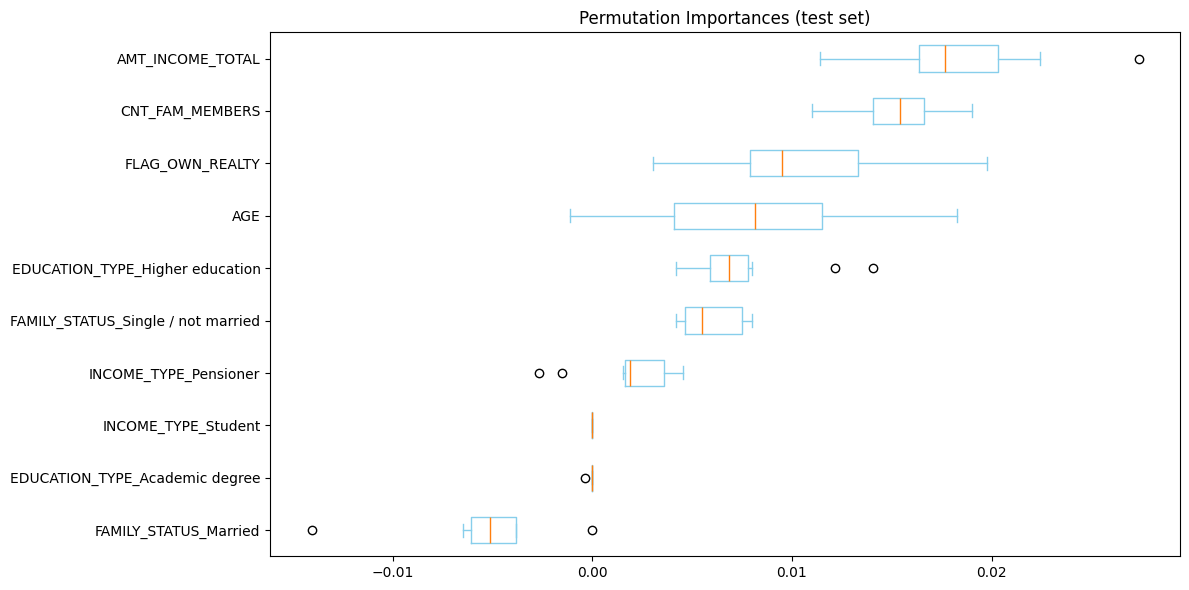

In [95]:
print("Permutation Importance: ", result.importances_mean)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test_rf.columns[sorted_idx], 
           boxprops=dict(color="skyblue"), whiskerprops=dict(color="skyblue"), capprops=dict(color="skyblue"))
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


/home/enrmic/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(


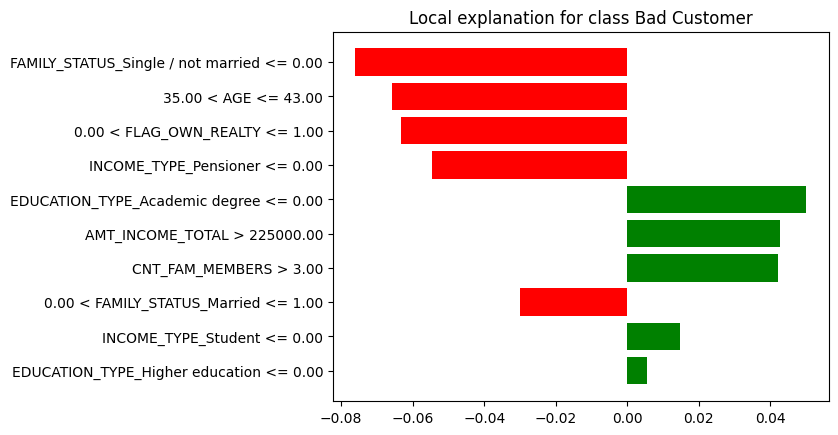

In [96]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_rf.values, feature_names=X_train_rf.columns, class_names=["Good Customer", "Bad Customer"], mode='classification', random_state=RANDOM_STATE)

idx = 0
exp = explainer.explain_instance(X_test_rf.values[idx], best_rnd_forest.predict_proba, num_features=len(X_test_rf.columns))

fig = exp.as_pyplot_figure()
plt.show()

There are several methods you can use to explain feature importance for a classification model. Some commonly used techniques include:

Feature Importance Scores: Many machine learning algorithms provide a built-in method to calculate feature importance scores. For example, decision trees and ensemble methods like Random Forest and Gradient Boosting typically offer feature importance scores based on how much they contribute to reducing impurity (e.g., Gini impurity or entropy).

Permutation Importance: This method involves permuting the values of each feature one at a time and observing how it affects the model's performance. Features that, when permuted, lead to the largest increase in model error are considered the most important.

Partial Dependence Plots: These plots show the relationship between a feature and the predicted outcome while marginalizing the effects of all other features. They can help visualize how the prediction changes as the value of a single feature varies.

SHAP (SHapley Additive exPlanations): SHAP values provide a way to estimate the contribution of each feature to the model's prediction. They are based on cooperative game theory and provide a unified approach to explain the output of any machine learning model.

LIME (Local Interpretable Model-agnostic Explanations): LIME explains the predictions of any classifier by approximating it with an interpretable model (such as linear regression) in the local neighborhood of the instance being explained.

ELI5 (Explain Like I'm 5): ELI5 is a Python library that provides a simple interface for explaining machine learning models. It supports various explanation methods, including permutation importance, LIME, and more.

Feature Contribution: For linear models, you can directly interpret feature coefficients as their contributions to the prediction. Features with larger coefficients are considered more important.

Each of these methods has its advantages and disadvantages, and the choice depends on factors such as the complexity of the model, the interpretability needed, and the specific characteristics of the data. It's often useful to explore multiple methods to gain a comprehensive understanding of feature importance in your classification model.